
 ## DeePlexiCon
 ### Analyse and demultiplex Oxford Nanopore RNA barcoded with DNA Adaptors Directly from the Signal
 
 Supplement Jupyter Notebook for the paper "Barcoding and demultiplexing Oxford Nanopore direct RNA sequencing reads using deep learning"
 
Preparation:


In [1]:
# System support
from __future__ import print_function
import os
import platform
from copy import deepcopy
import re
import csv
import time
import configparser
# Math,Numpy and plot
import math
import numpy as np
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
#import PIL
#from PIL import Image
# Time series to 2D
import pyts
# Tensorflow - Keras
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import multi_gpu_model
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
# Datasets, train test split
import pandas as pd
import sklearn
from sklearn import datasets, linear_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd

import seaborn as sn

Using TensorFlow backend.


In [2]:
def version_from_system(package):
    pkg_info=!pip show {package}
    return(pkg_info[1][9:])   

print("Python       version :",platform.python_version())
print("pip          version :",version_from_system('pip'))
print("Tensorflow   version :",tf.__version__)
print("Keras        version :",keras.__version__)
print("Numpy        version :",np.__version__)
print("Matplotlib   version :",matplotlib.__version__)
print("Pandas       version :",pd.__version__)
print("PyTs         version :",pyts.__version__)
print("Scikit-learn version :",sklearn.__version__)
#print("PIL          version :",PIL.__version__)
print("Seaborn      version :",sn.__version__)
print("PYCM         version :",version_from_system('pycm'))

Python       version : 3.7.3
pip          version : 19.1.1
Tensorflow   version : 1.13.1
Keras        version : 2.2.4
Numpy        version : 1.16.4
Matplotlib   version : 3.1.0
Pandas       version : 0.25.0
PyTs         version : 0.8.0
Scikit-learn version : 0.21.2
Seaborn      version : 0.9.0
PYCM         version : 2.4


In [4]:
# Parameters
run='rep4-on-rep3-test1'
gpus=1
epochs=40
input_cut=70000
input_data_paths=['/data/nanopore/James/Barcodes/rep4']
input_segment_paths=['/data/nanopore/James/Barcodes/rep4']#, '/data/nanopore/James/Barcodes/final-07-19/seg/rep2-split']
squiggle_max=199.0
squiggle_min=10
print_details_for=5
max_sample=45000
read_max=180000
smooth_by=1
num_classes=4
label_index=0
save_figures=True

In [5]:
!mkdir -p {run}

In [6]:
10# Python timeseries interface
from pyts.image import MarkovTransitionField, GramianAngularField, RecurrencePlot
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 6,
        }
# Python timeseries interface
def pyts_transform(name,transform,data,image_size,show=False,cmap='rainbow',img_index=0):
    try:
        X_transform = transform.fit_transform(data)
        if (show):
            tcn=transform.__class__.__name__
            if hasattr(transform, 'method'):
                tcn=tcn+'-'+transform.method
            plt.figure(figsize=(4, 4))
            plt.grid(b=None)
            plt.title(name,fontdict=font)
            plt.imshow(X_transform[0], cmap=cmap, origin='lower')
            if save_figures: plt.savefig(run+"/"+name+'-'+tcn+"_image_"+ str(img_index)+".svg", format="svg")
            plt.show()
        return(X_transform)
    except Exception as e:
        print('Error:', str(e))
        return([])
        
def mtf_transform(name,data,image_size = 500,show=False,img_index=0):
    transform = MarkovTransitionField(image_size)    
    return(name,pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='rainbow',img_index=img_index))
    
def rp_transform(name,data,image_size = 500,show=False,img_index=0):
    # RP transformation
    transform = RecurrencePlot(dimension=1, 
                    threshold='percentage_points',
                    percentage=30)
    return(pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='binary',img_index=img_index))
    
def gasf_transform(name,data,image_size = 500,show=False,img_index=0):
    # GAF transformation
    transform = GramianAngularField(image_size, method='summation')
    return(pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='rainbow',img_index=img_index))

def gadf_transform(name,data,image_size = 500,show=False,img_index=0):
    # GAF transformation
    transform = GramianAngularField(image_size, method='difference')
    return(name,pyts_transform(name,transform,data,image_size = image_size,show=show,cmap='rainbow',img_index=img_index))
     


In [7]:
def all_files_in_path(input_path,prefix, extension):
    return([f for f in os.listdir(input_path) if f.startswith(prefix) & f.endswith(extension)])

def full_paths_for_files_in_path(input_path,prefix, extension):
    return([input_path+'/'+f for f in os.listdir(input_path) if f.startswith(prefix) & f.endswith(extension)])

def labels_for(file_name):
    segments=re.split(r'[_\-\.]+', file_name)
    return(segments)

def label_for(file_name):
    return('BC'+labels_for(file_name)[label_index][-1])

def max_in_sequence(sequence):   
    return(max(np.amax([list(d.values()) for d in sequence]),0.01))

In [8]:
for file_name in all_files_in_path(input_segment_paths[0],'', 'dmux.tsv'):
    print(file_name,label_for(file_name))

BC3-rep4_cc6m_2595_T7_ecorv_cc3.txt_dmux.tsv BC3
BC2-rep4_cc6m_2459_T7_ecorv_cc2.txt_dmux.tsv BC2
BC2-rep4_R1_81_2.txt_dmux.tsv BC2
BC4-rep4_R2_117_1.txt_dmux.tsv BC4
BC3-rep4_R1_103_1.txt_dmux.tsv BC3
BC1-rep4_cc6m_2244_T7_ecorv_cc1.txt_dmux.tsv BC1
BC4-rep4_cc6m_2709_T7_ecorv_cc4.txt_dmux.tsv BC4
BC1-rep4_R2_63_3.txt_dmux.tsv BC1


In [9]:
def read_segment_files(paths,postfix,usecols=[0,1,2, 8,9],index_column=1, names=['source','read_id','barcode', 'segment_start','segment_end']):
    all_segment_files=[]
    for path in paths:
        all_segment_files=all_segment_files+full_paths_for_files_in_path(path,'',postfix)
    print("Reading segment files:", all_segment_files)
    segments=[]
    for f in all_segment_files:
        segment_label=label_for(os.path.basename(f)) # Assuming Linux, may fail with Windows
        segment=pd.read_table(f, usecols=usecols, names=names, index_col=index_column, header=None, sep="\t",skiprows=[0])
        segment['label']=segment_label
        segments.append(segment)
    segments=pd.concat(segments)
    print(len(segments))
    segments = segments[~segments.index.duplicated(keep='first')]
    print(len(segments))
    return(segments)

In [10]:
print(full_paths_for_files_in_path(input_segment_paths[0],'', '.tsv'))

['/data/nanopore/James/Barcodes/rep4/rep4_R2_63_3.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep4/rep4_R1_81_2.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep4/rep4_R2_117_1.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep4/rep4_cc6m_2459_T7_ecorv_cc2.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep4/BC3-rep4_cc6m_2595_T7_ecorv_cc3.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC2-rep4_cc6m_2459_T7_ecorv_cc2.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC2-rep4_R1_81_2.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC4-rep4_R2_117_1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC3-rep4_R1_103_1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC1-rep4_cc6m_2244_T7_ecorv_cc1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/rep4_cc6m_2244_T7_ecorv_cc1.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep4/rep4_R1_103_1.txt_squiggle.tsv', '/data/nanopore/James/Barcodes/rep4/BC4-rep4_cc6m_2709_T7_ecorv_cc4.txt_dmux.tsv', '/data/nanopore/James

In [11]:
segments=read_segment_files(input_segment_paths, 'dmux.tsv')
segments

Reading segment files: ['/data/nanopore/James/Barcodes/rep4/BC3-rep4_cc6m_2595_T7_ecorv_cc3.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC2-rep4_cc6m_2459_T7_ecorv_cc2.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC2-rep4_R1_81_2.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC4-rep4_R2_117_1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC3-rep4_R1_103_1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC1-rep4_cc6m_2244_T7_ecorv_cc1.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC4-rep4_cc6m_2709_T7_ecorv_cc4.txt_dmux.tsv', '/data/nanopore/James/Barcodes/rep4/BC1-rep4_R2_63_3.txt_dmux.tsv']
60650
60650


source  \
read_id                                                                                   
0023230d-fcba-40f7-a6e3-b4575fe47c2c  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
005d27eb-f36f-46f9-944b-45a79849a550  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
00c29052-4054-493a-9814-b908d8c6a3ea  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
00cf681d-10d4-4905-8e81-09a37a5d1f33  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
014001b3-be18-4f54-b66d-baa71418e022  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
...                                                                                 ...   
e5d3a34d-a663-4d35-aa2b-0078fa86fca8  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
ee81a7dd-076d-4fb2-bf2b-0606f5ac0327  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
ef35905a-bb70-45e1-a7da-ceb9eba74127  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
f855ce47-acd7-4bcd-b273-66d0fc1026e1  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
fff2aba9-689f-4252-a912-8e4f9d4148a3  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   

                                     barcode  segment_start  segment_end label  
read_id                                                                         
0023230d-fcba-40f7-a6e3-b4575fe47c2c    bc_3           2281         7534   BC3  
005d27eb-f36f-46f9-944b-45a79849a550    bc_3           1268         5332   BC3  
00c29052-4054-493a-9814-b908d8c6a3ea    bc_3           2230         4668   BC3  
00cf681d-10d4-4905-8e81-09a37a5d1f33    bc_4            999         3981   BC3  
014001b3-be18-4f54-b66d-baa71418e022    bc_3            999         3331   BC3  
...                                      ...            ...          ...   ...  
e5d3a34d-a663-4d35-aa2b-0078fa86fca8    bc_4           3426        12077   BC1  
ee81a7dd-076d-4fb2-bf2b-0606f5ac0327    bc_4           3498        10967   BC1  
ef35905a-bb70-45e1-a7da-ceb9eba74127    bc_2           2473         5384   BC1  
f855ce47-acd7-4bcd-b273-66d0fc1026e1    bc_1           1437         5041   BC1  
fff2aba9-689f-4252-a912-8e4f9d4148a3    bc_1           1026         4852   BC1  

[60650 rows x 5 columns]

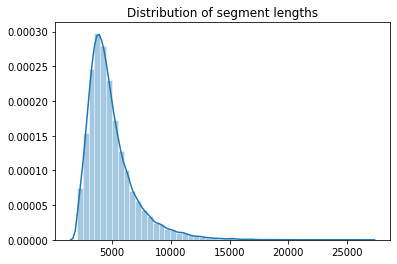

In [12]:
from matplotlib.ticker import FuncFormatter

seg_lengths=segments['segment_end']-segments['segment_start']+1
#seg_lengths=seg_lengths[seg_lengths<20000]
#print(seg_lengths[0:20])

plt.figure("Distribution of segment lengths")
plt.title("Distribution of segment lengths")
sn.set(rc={'figure.figsize':(18.7,10.27)})
sn.set_style("whitegrid")
sn.distplot(seg_lengths)#, bins=100, kde=False, color="blue", label="S1")
#plt.legend()
if save_figures: plt.savefig(run+"/seglengthdist1.svg", format="svg")
plt.show()
seg_lengths=None


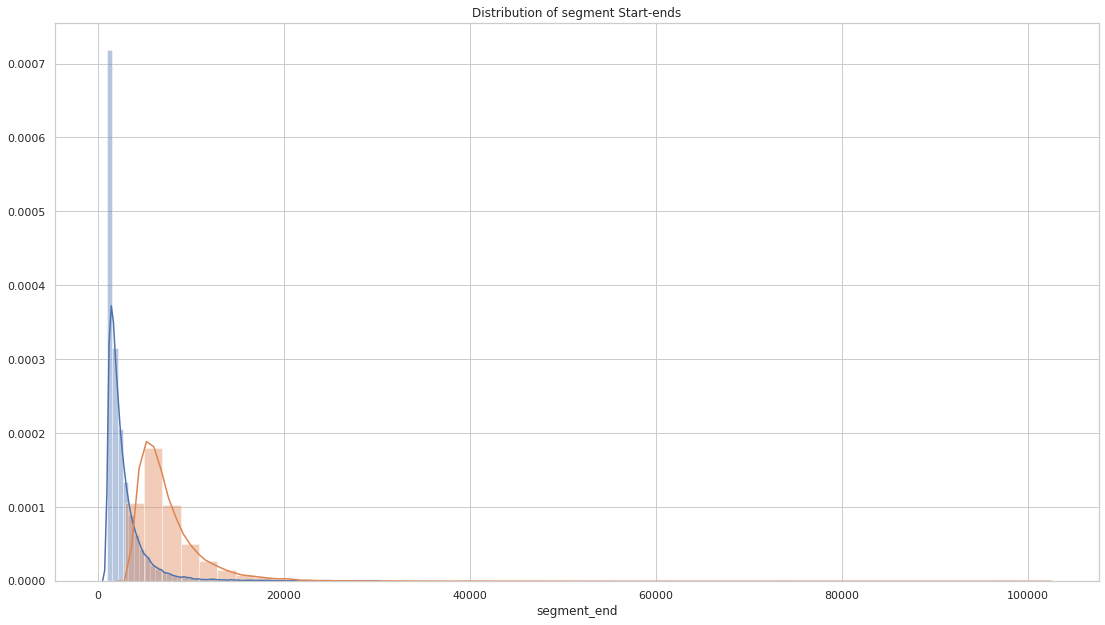

In [13]:

plt.figure("Distribution of segment Start-ends")
plt.title("Distribution of segment Start-ends")
sn.set(rc={'figure.figsize':(18.7,10.27)})
sn.set_style("whitegrid")
sn.distplot(segments['segment_start'][segments['segment_start']<30000])#, bins=100, kde=False, color="blue", label="S1")
sn.distplot(segments['segment_end'])#, bins=100, kde=False, color="blue", label="S1")
#plt.legend()
if save_figures: plt.savefig(run+"/segst-end-dist1.svg", format="svg")
plt.show()



In [14]:
segments.loc['03f3bb7f-7d34-4b17-b045-cdac3aab6a81']

source           FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...
barcode                                                       bc_4
segment_start                                                 2778
segment_end                                                   5849
label                                                          BC3
Name: 03f3bb7f-7d34-4b17-b045-cdac3aab6a81, dtype: object

In [15]:
segments.describe()

segment_start    segment_end
count   60650.000000   60650.000000
mean     2686.774114    7588.307304
std      3262.960547    4140.957543
min       999.000000    2999.000000
25%      1139.000000    5183.000000
50%      1814.000000    6534.000000
75%      2951.000000    8665.000000
max     91089.000000  101601.000000

In [16]:
far_ends= segments[segments['segment_end']>30000]

In [17]:
long_segments= segments[(segments['segment_end']-segments['segment_start'])>30000]

In [42]:
far_ends

source  \
read_id                                                                                   
41bf255c-02ad-4ffa-b67f-e8cdad5fad42  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
7e75f5d8-448a-403d-ae43-578a340fa89b  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
8c22b900-283c-422b-bae0-ce042aa71739  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
c87f615c-c9d6-4070-855f-619e36842211  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
8ffde4fb-6d32-4b90-a376-7c256f8b3817  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
...                                                                                 ...   
1fd22882-c747-438d-96e0-078fbd049988  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
56af1760-d388-49ef-ae1f-266e99206841  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
d523ee78-e04a-44f8-8d15-a4775f5280e8  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
95008b11-b7be-4904-a425-0f7d181c61f5  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   
d9b56594-d902-4ca1-b2fd-31c74c34f8e3  FAL18505_fccbc80b8b81a4540fc5188e93969fe2aa7fe...   

                                      barcode  segment_start  segment_end  \
read_id                                                                     
41bf255c-02ad-4ffa-b67f-e8cdad5fad42  unknown          49773        53572   
7e75f5d8-448a-403d-ae43-578a340fa89b     bc_3          40562        42675   
8c22b900-283c-422b-bae0-ce042aa71739     bc_2          18838        35363   
c87f615c-c9d6-4070-855f-619e36842211     bc_2          25145        31372   
8ffde4fb-6d32-4b90-a376-7c256f8b3817     bc_3          40369        43587   
...                                       ...            ...          ...   
1fd22882-c747-438d-96e0-078fbd049988     bc_3          32967        41276   
56af1760-d388-49ef-ae1f-266e99206841     bc_3          36025        42231   
d523ee78-e04a-44f8-8d15-a4775f5280e8     bc_4          25823        31746   
95008b11-b7be-4904-a425-0f7d181c61f5     bc_3          44327        46934   
d9b56594-d902-4ca1-b2fd-31c74c34f8e3     bc_2          30920        34850   

                                     label  
read_id                                     
41bf255c-02ad-4ffa-b67f-e8cdad5fad42   BC3  
7e75f5d8-448a-403d-ae43-578a340fa89b   BC3  
8c22b900-283c-422b-bae0-ce042aa71739   BC3  
c87f615c-c9d6-4070-855f-619e36842211   BC3  
8ffde4fb-6d32-4b90-a376-7c256f8b3817   BC3  
...                                    ...  
1fd22882-c747-438d-96e0-078fbd049988   BC4  
56af1760-d388-49ef-ae1f-266e99206841   BC4  
d523ee78-e04a-44f8-8d15-a4775f5280e8   BC4  
95008b11-b7be-4904-a425-0f7d181c61f5   BC4  
d9b56594-d902-4ca1-b2fd-31c74c34f8e3   BC4  

[265 rows x 5 columns]

In [43]:
long_segments

Empty DataFrame
Columns: [source, barcode, segment_start, segment_end, label]
Index: []

In [45]:
fe_csv = far_ends.to_csv (run+'/far_ends.csv',  header=True)
ls_csv = long_segments.to_csv (run+'/long_segments.csv',  header=True)

In [18]:
offset=-999
buffer=0
def segment_by_read_name(read_name):
    try:
        seg=segments.loc[read_name]
        return(seg['segment_start']+offset-buffer,seg['segment_end']+buffer,seg['label'])
    except:
        return(None,None, None)

In [19]:
segment_by_read_name('03f3bb7f-7d34-4b17-b045-cdac3aab6a81')

(1779, 5849, 'BC3')

In [22]:
files_to_process=[]
for path in input_data_paths:
    files_to_process=files_to_process+all_files_in_path(path,'','squiggle.tsv')

print (len(files_to_process))
for f in files_to_process:
    print(labels_for(f))

8
['rep4', 'R2', '63', '3', 'txt', 'squiggle', 'tsv']
['rep4', 'R1', '81', '2', 'txt', 'squiggle', 'tsv']
['rep4', 'R2', '117', '1', 'txt', 'squiggle', 'tsv']
['rep4', 'cc6m', '2459', 'T7', 'ecorv', 'cc2', 'txt', 'squiggle', 'tsv']
['rep4', 'cc6m', '2244', 'T7', 'ecorv', 'cc1', 'txt', 'squiggle', 'tsv']
['rep4', 'R1', '103', '1', 'txt', 'squiggle', 'tsv']
['rep4', 'cc6m', '2709', 'T7', 'ecorv', 'cc4', 'txt', 'squiggle', 'tsv']
['rep4', 'cc6m', '2595', 'T7', 'ecorv', 'cc3', 'txt', 'squiggle', 'tsv']


In [23]:
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
image_size=224
samples={'BC1':0,'BC2':0,'BC3':0,'BC4':0}
def compress_squiggle(squiggle,compress_factor):
    squiggle_len=len(squiggle)
    rem=squiggle_len%compress_factor
    if rem>0:
        return(np.mean(squiggle[0:squiggle_len-rem].reshape(-1,compress_factor), axis=1))
    return(squiggle)
    
def show_graph(squiggle_label,squiggle, trimmed_squiggle,segments=[], img_index=0):
    squiggle_for_plot=pd.DataFrame(np.trim_zeros(squiggle))
    plt.figure(figsize=(15,2))
    plt.grid(True)
    for seg in segments:
        plt.axvline(x=seg[0]/smooth_by, color=seg[2])
        plt.axvline(x=seg[1]/smooth_by, color=seg[2])
    plt.plot(squiggle_for_plot, linewidth=0.1, color='black')
    plt.title(squiggle_label)
    if save_figures: plt.savefig(run+"/"+squiggle_label+"-squiggle"+ str(img_index)+".svg", format="svg")
    plt.show()
    plt.figure(figsize=(15,2))
    plt.plot(trimmed_squiggle, linewidth=0.2, color='black')
    plt.title(squiggle_label)
    plt.grid(True)
    if save_figures: plt.savefig(run+"/"+squiggle_label+"-seg-squiggle-"+str(img_index)+".svg", format="svg")
    plt.show()
    
def process_file(data_path,file_to_process,  pos_from, pos_to):
    print('Processing file:', file_to_process)
    squiggles=[]
    squiggle_labels=[]
    start_from=2
    start=time.time()
    printed_details=0
    image_index=0
    labels=[]
    result=[]
    lines_read=0
    with open(data_path+'/'+file_to_process) as tsv:
        for line in csv.reader(tsv, dialect="excel-tab"):
#            try:
                squiggle_label=line[0]
                segment_start,segment_end, label=segment_by_read_name(squiggle_label)
                segments=[[segment_start, segment_end, 'r']]
                if segment_start is not None:
                    squiggle=np.array(line[start_from:], dtype=np.float32)
                    if len(squiggle)>=image_size:
                        lines_read=lines_read+1
                        #take average of every n points to compress by n
                        if (smooth_by > 1) and (len(squiggle)> smooth_by * image_size):
                            squiggle=compress_squiggle(squiggle,smooth_by) 
                            segment_start=int(segment_start/smooth_by)
                            segment_end=int(segment_end/smooth_by)
                        trimmed_squiggle=squiggle[segment_start:segment_end+1]
                        squiggle=squiggle[squiggle <= squiggle_max]
                        squiggle=squiggle[squiggle > squiggle_min]
                        trimmed_squiggle=trimmed_squiggle[trimmed_squiggle <= squiggle_max]
                        trimmed_squiggle=trimmed_squiggle[trimmed_squiggle > squiggle_min]
                        trimmed_squiggle=np.trim_zeros(trimmed_squiggle)
                        display_graph=printed_details<print_details_for
                        name=label+'-'+squiggle_label
                        if (display_graph):
                            print("Reading:", squiggle_label)
                            show_graph(name,squiggle,trimmed_squiggle,segments=segments,img_index=image_index)
                            image_index=image_index+1
                            printed_details=printed_details+1
#                        transformed_squiggle=mtf_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
#                        transformed_squiggle=rp_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
#                        transformed_squiggle=gadf_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
                        transformed_squiggle=gasf_transform(name,trimmed_squiggle.reshape(1,-1),image_size=image_size, show=display_graph,img_index=image_index)
                        if (display_graph):
                            image_index=image_index+1
                        if len(transformed_squiggle)>0:
                            if samples[label]<max_sample:
                                transformed_squiggle=transformed_squiggle[None,...]
                                result.append([label,squiggle_label, transformed_squiggle])
                                samples[label]=samples[label]+1
                        else:
                            print("Transformation fails:", squiggle_label,len(transformed_squiggle))
                    else:
                        print("Short:", squiggle_label,len(squiggle))
                else:
                    print("No segment info for:", squiggle_label)
                if (lines_read>=read_max) or (min(samples.values())>=max_sample):
                    break
#            except Exception as e:
#               print('Error:', str(e),segment_start)
    print( "Number of Squiggles=", len(result))
    print(time.time()-start, ' seconds') 
    return(result)#[labels, squiggle_labels,squiggles])


/data/nanopore/James/Barcodes/rep4
File name= /data/nanopore/James/Barcodes/rep4/rep4_R2_63_3.txt_squiggle.tsv
Processing file: rep4_R2_63_3.txt_squiggle.tsv
Reading: 0fa6ed8e-0fd3-4c19-8e67-00d197dc6f72


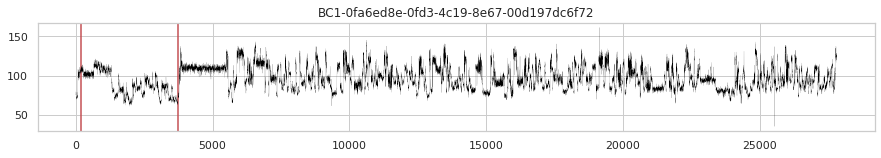

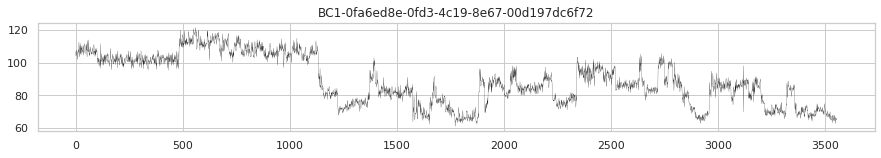

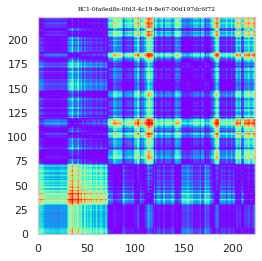

Reading: 1204f5d2-81c5-4002-8f9e-1688baeec934


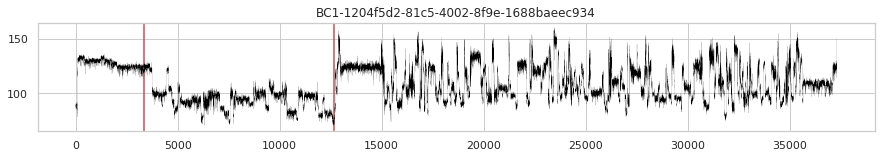

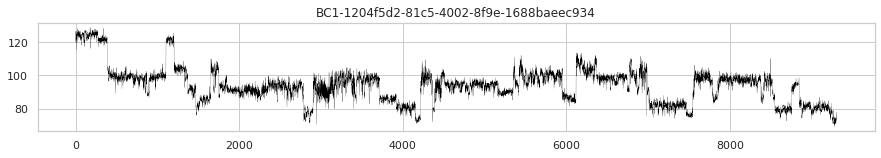

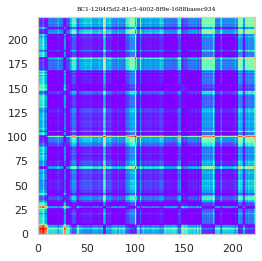

Reading: 32f054f7-7ebf-4e1d-bff4-def5a9d52945


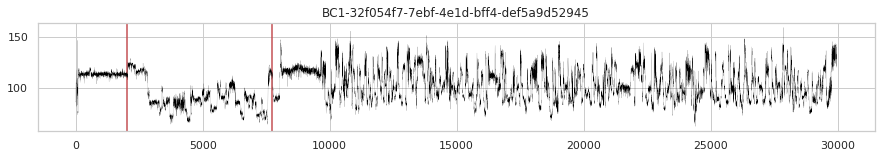

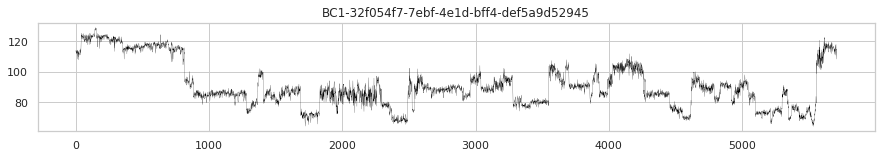

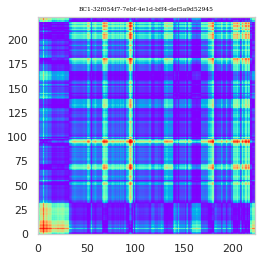

Reading: 365331a6-2acc-4f20-a932-f3f49285c336


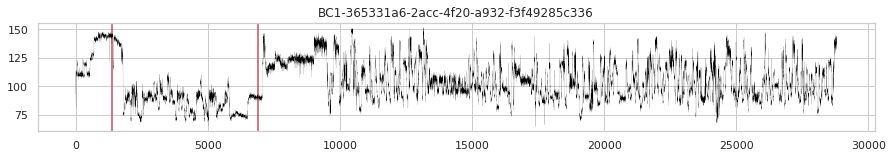

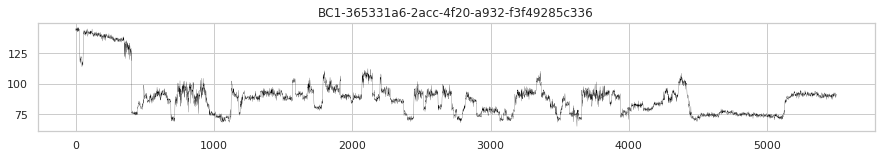

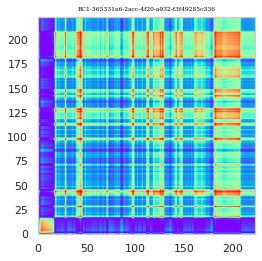

Reading: 47d090ed-f4c5-41c8-b472-0c2952e609ed


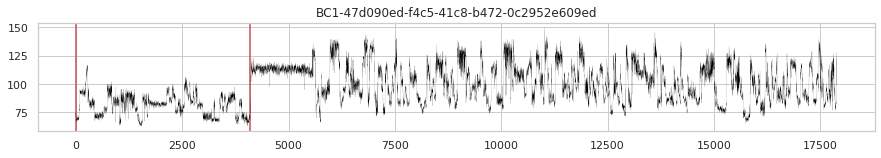

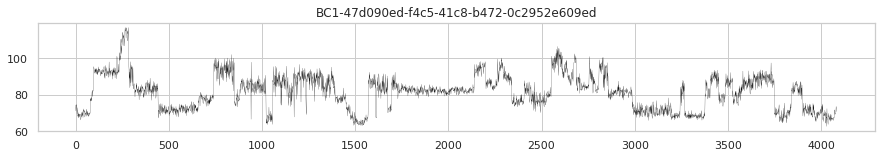

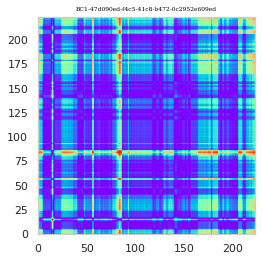

Number of Squiggles= 915
18.092915773391724  seconds
BC1 = 915 samples now
File name= /data/nanopore/James/Barcodes/rep4/rep4_R1_81_2.txt_squiggle.tsv
Processing file: rep4_R1_81_2.txt_squiggle.tsv
Reading: f309c258-a9aa-420f-8b52-1622907693dc


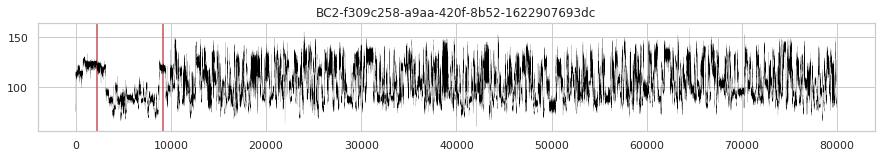

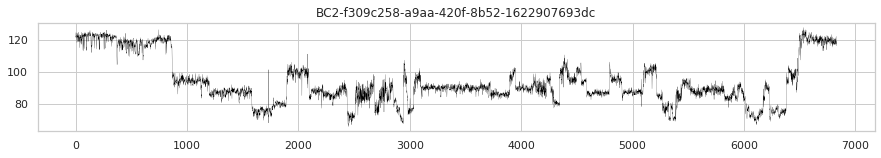

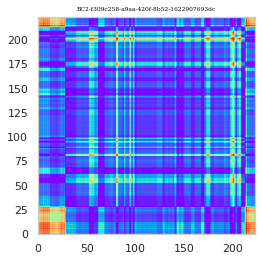

Reading: b12db211-2beb-4ef8-b2f1-026856772900


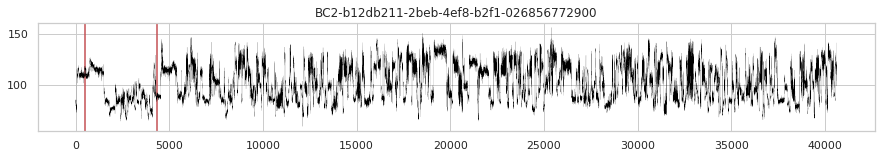

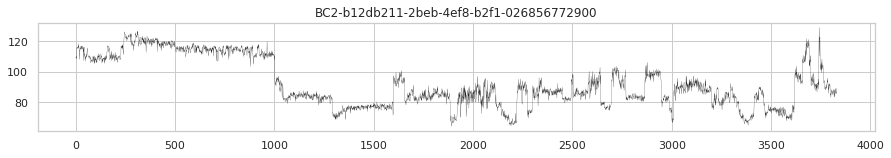

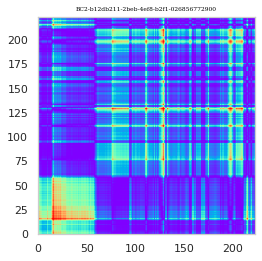

Reading: 381485a0-766c-49f2-8db2-a7bdfa9ec63a


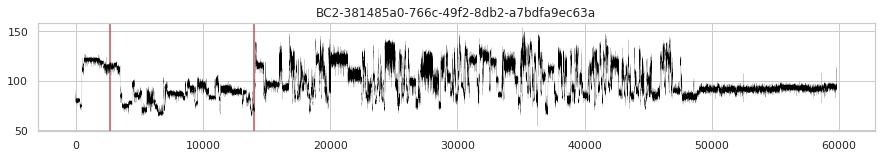

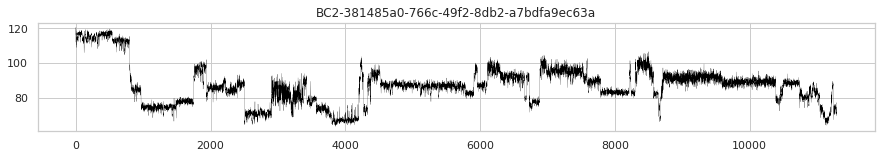

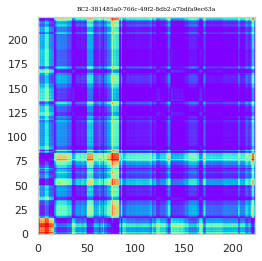

Reading: 858479a6-30e1-41ad-bc61-64e226bfc9ae


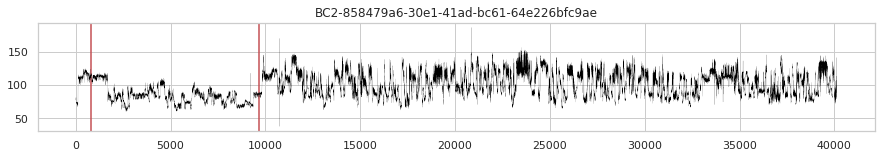

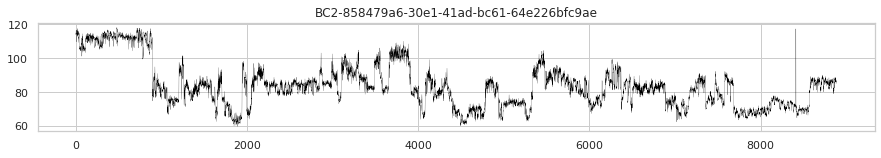

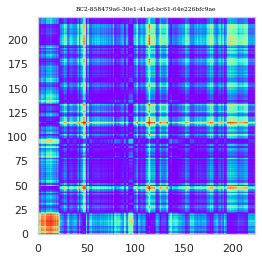

Reading: 9377f7f7-9478-420f-934e-895bc3fa8eb4


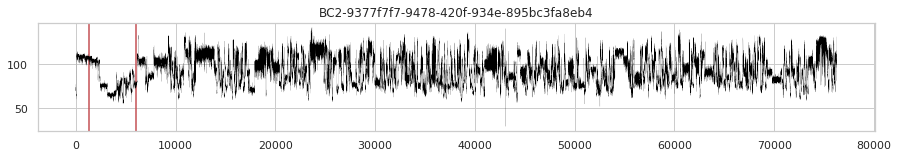

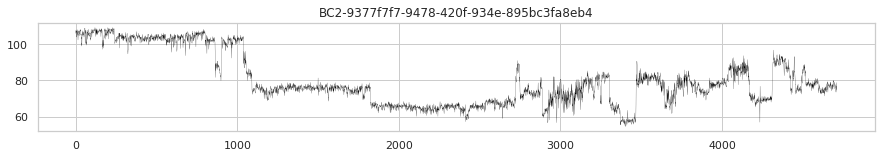

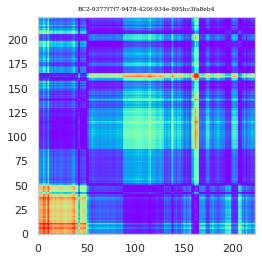

Number of Squiggles= 22
5.809752702713013  seconds
BC1 = 915 samples now
BC2 = 22 samples now
File name= /data/nanopore/James/Barcodes/rep4/rep4_R2_117_1.txt_squiggle.tsv
Processing file: rep4_R2_117_1.txt_squiggle.tsv
Reading: 09e47947-c556-4264-9c5a-699b2f0a69be


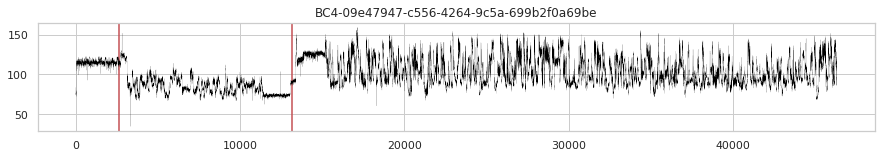

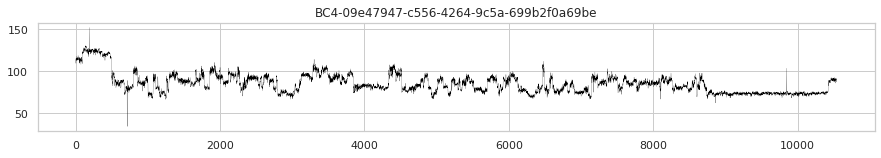

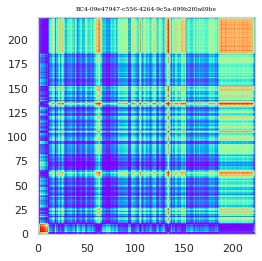

Reading: 0a4aa0a6-6345-4cd2-928f-f2237ff4c29c


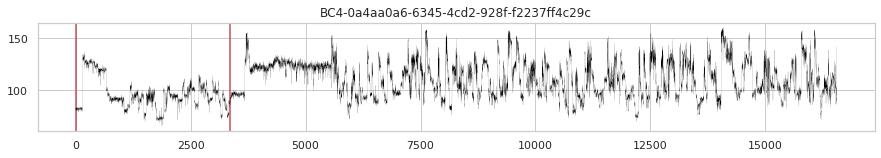

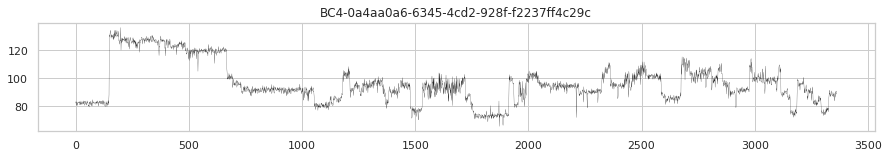

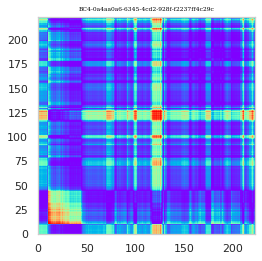

Reading: 0fb12e06-ea13-42ce-b2ca-6db816270da0


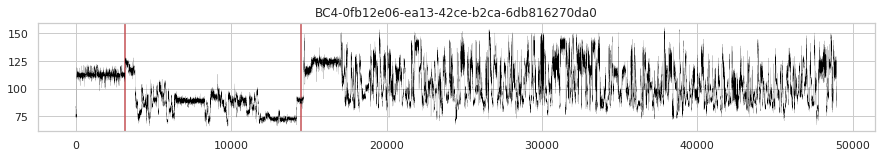

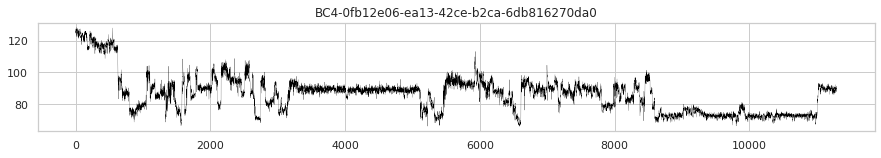

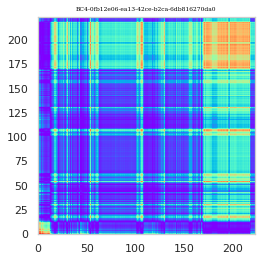

Reading: 1eec5375-117d-452d-9dcb-6090e64a333e


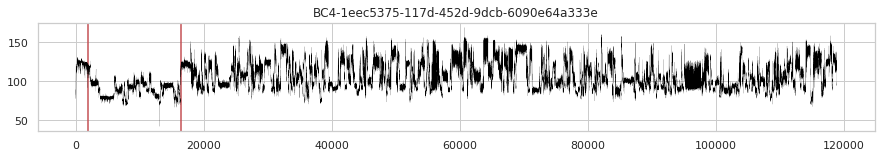

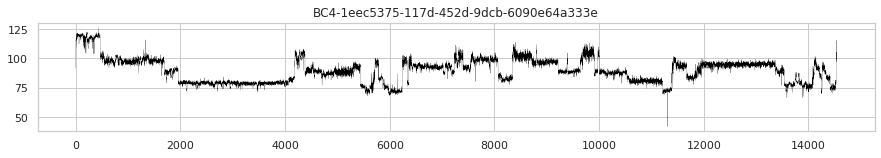

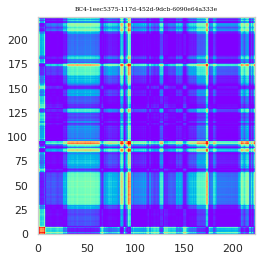

Reading: 2aeb59ad-5a9d-417e-b350-ea75e447d401


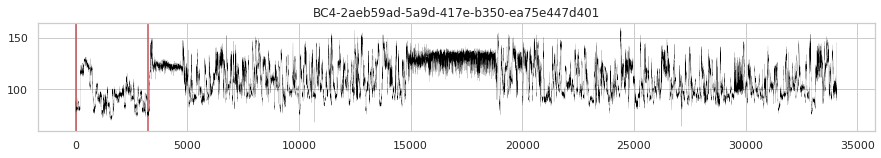

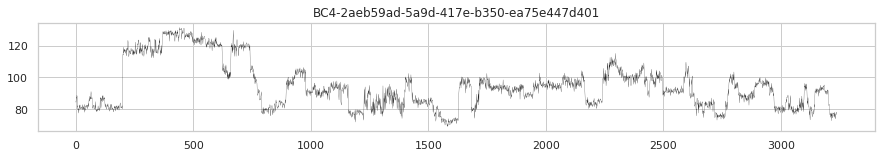

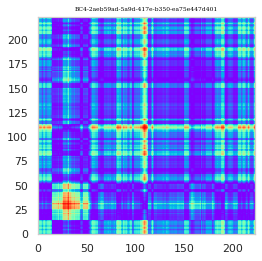

Number of Squiggles= 767
17.187855005264282  seconds
BC1 = 915 samples now
BC2 = 22 samples now
BC4 = 767 samples now
File name= /data/nanopore/James/Barcodes/rep4/rep4_cc6m_2459_T7_ecorv_cc2.txt_squiggle.tsv
Processing file: rep4_cc6m_2459_T7_ecorv_cc2.txt_squiggle.tsv
Reading: 02377c85-0c52-40dc-82a4-0fe3ad9a4045


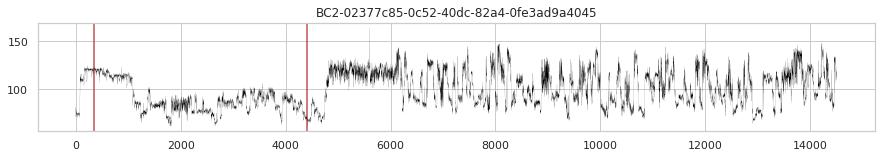

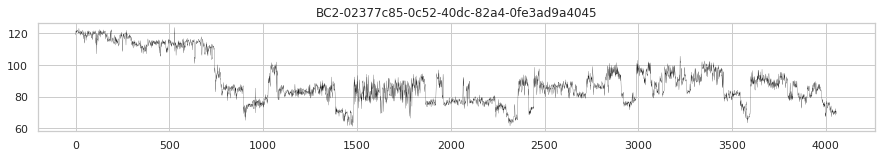

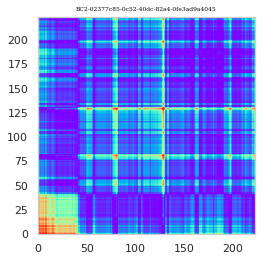

Reading: 032f3d73-d0d5-44f6-b3e9-92ec6bea2ed4


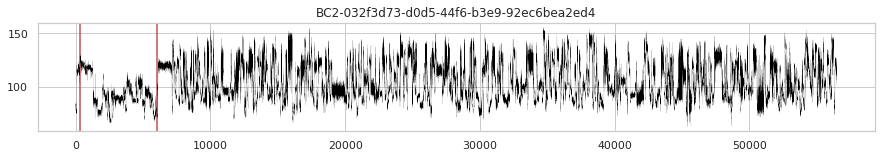

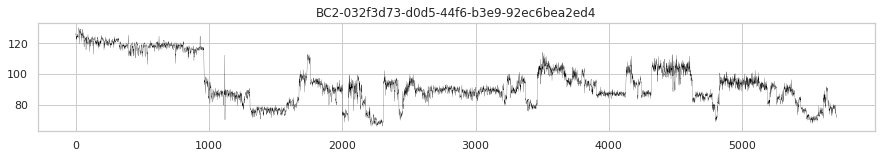

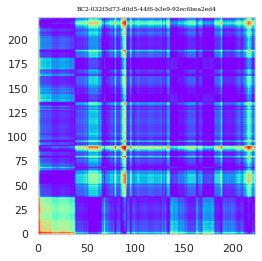

Reading: 04842866-8094-4d2e-84c3-28c8bc530543


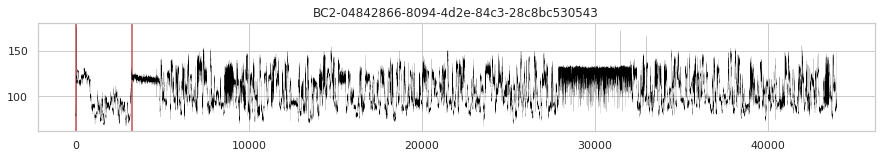

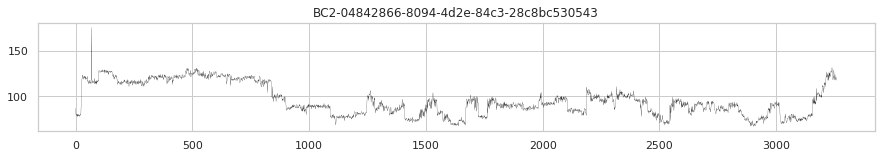

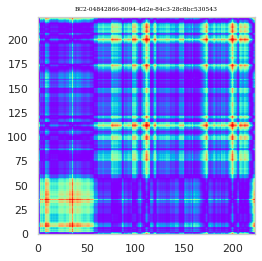

Reading: 0496e84f-b042-4450-8d79-ee78a7f76cda


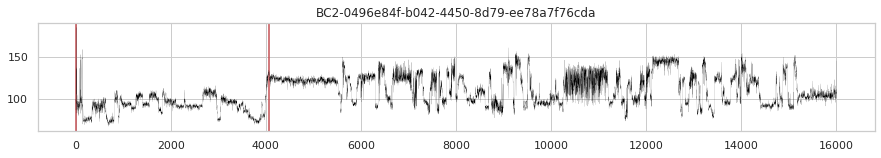

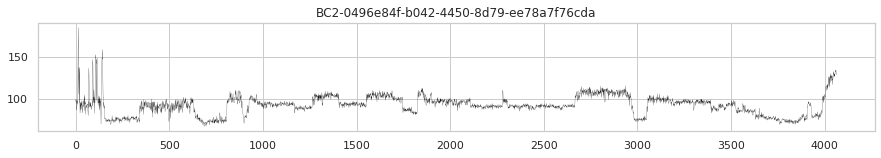

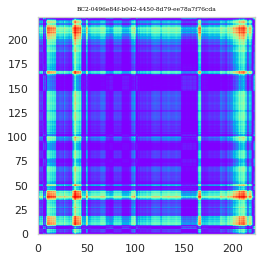

Reading: 086aa6e0-1f00-4c77-ba15-c06f78badf13


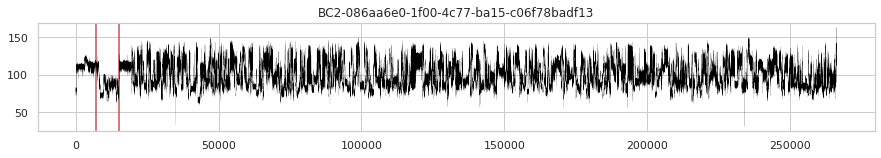

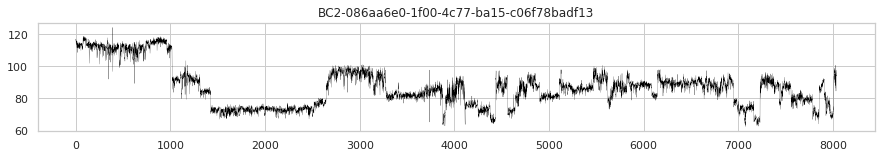

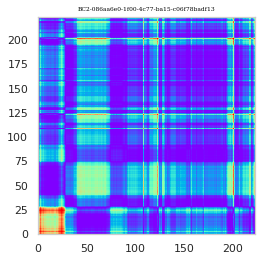

Number of Squiggles= 10735
278.21488189697266  seconds
BC1 = 915 samples now
BC2 = 10757 samples now
BC4 = 767 samples now
File name= /data/nanopore/James/Barcodes/rep4/rep4_cc6m_2244_T7_ecorv_cc1.txt_squiggle.tsv
Processing file: rep4_cc6m_2244_T7_ecorv_cc1.txt_squiggle.tsv
Reading: 00b6def8-afca-4dd8-91c7-9774bd2aa705


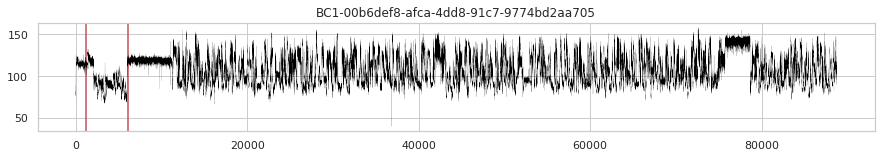

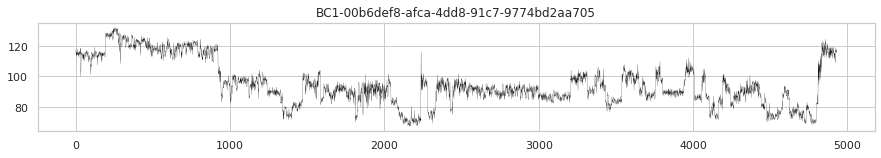

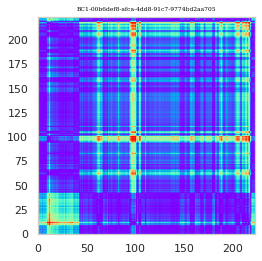

Reading: 014b3cb4-5c46-4180-9f7e-dbbf99f908b5


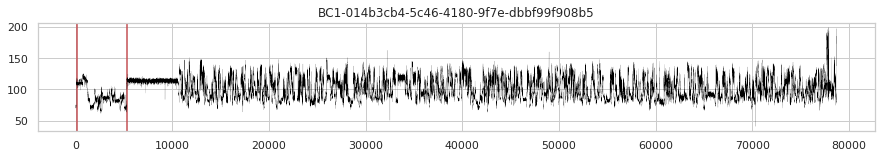

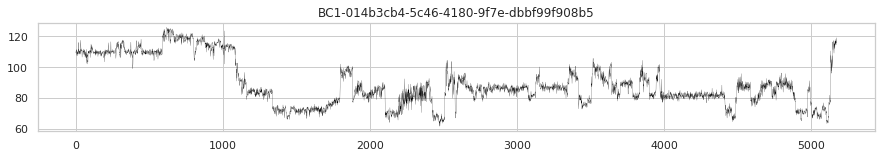

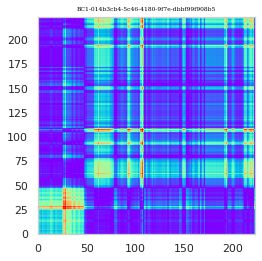

Reading: 01f9f946-458d-472b-acd1-1beea4d20376


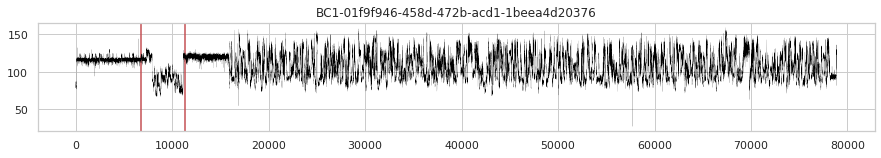

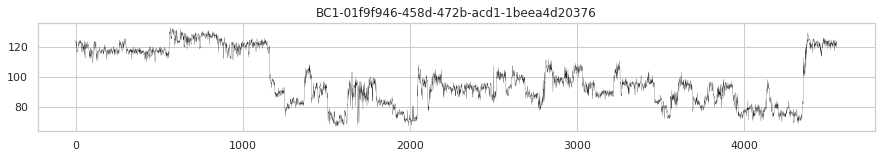

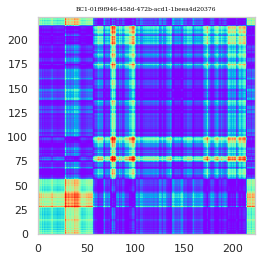

Reading: 042c16ab-4793-4f49-b6c1-f1f1968c2425


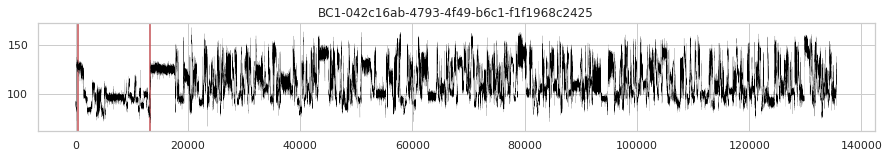

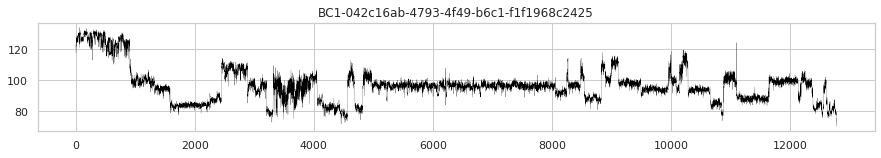

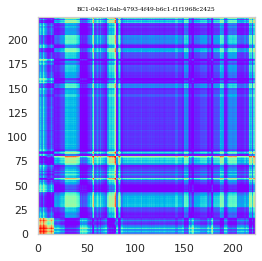

Reading: 042cc8e9-e04b-4b6b-9e47-25e623b76f88


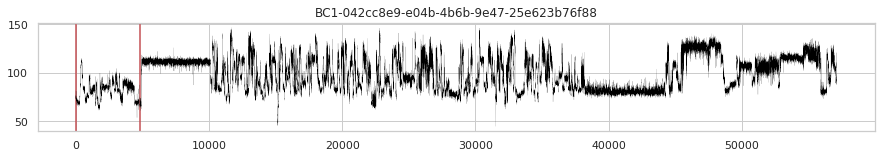

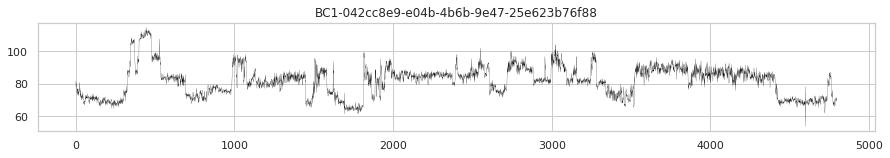

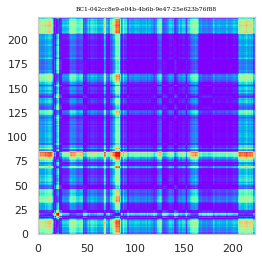

Number of Squiggles= 14965
364.42930126190186  seconds
BC1 = 15880 samples now
BC2 = 10757 samples now
BC4 = 767 samples now
File name= /data/nanopore/James/Barcodes/rep4/rep4_R1_103_1.txt_squiggle.tsv
Processing file: rep4_R1_103_1.txt_squiggle.tsv
Reading: 90ecba3e-9b13-4b50-bcf7-d9af03328025


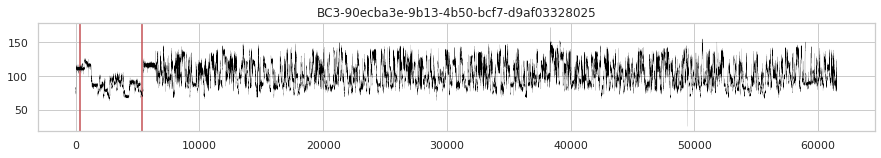

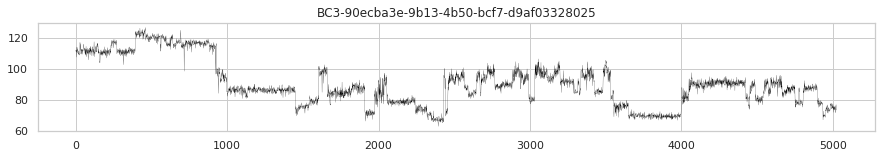

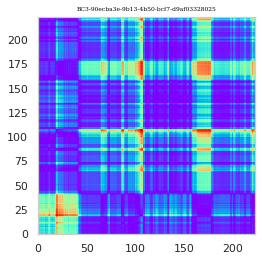

Reading: c7fa359b-164b-4d32-ac8b-1c5bedce88ee


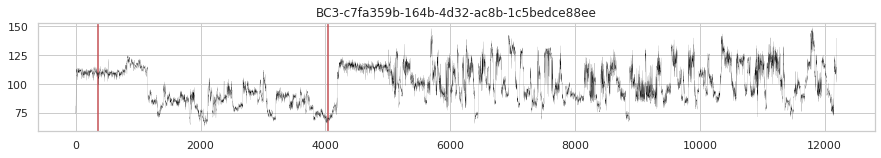

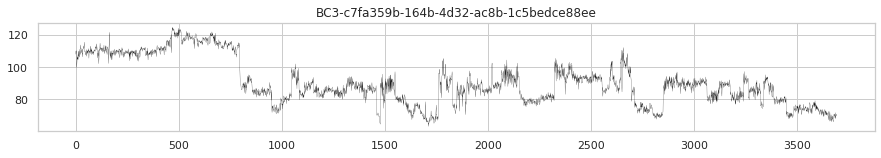

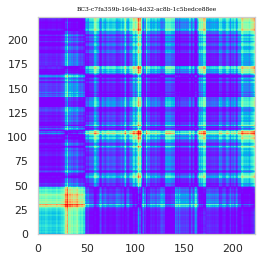

Reading: 008d489d-611f-4354-ab73-5ed286adb677


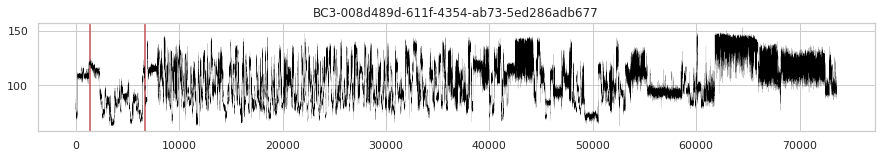

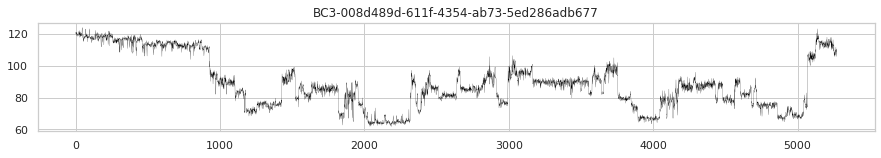

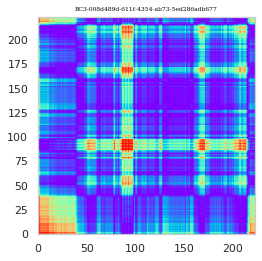

Reading: 1854d3a9-041f-4a6e-b4ca-918572c2fd37


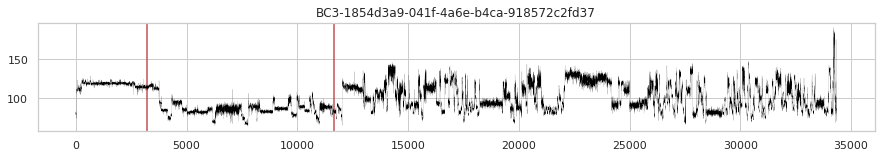

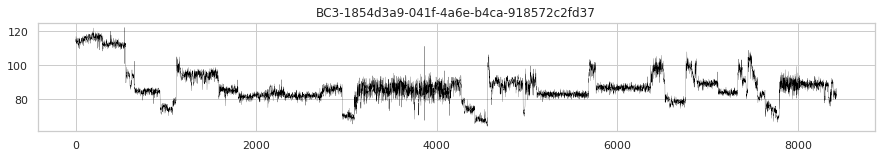

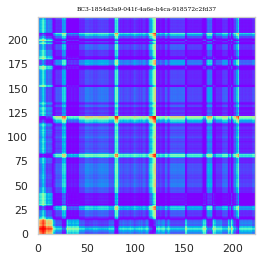

Reading: 955af049-7e2f-4989-8b10-5bc3f1b42b10


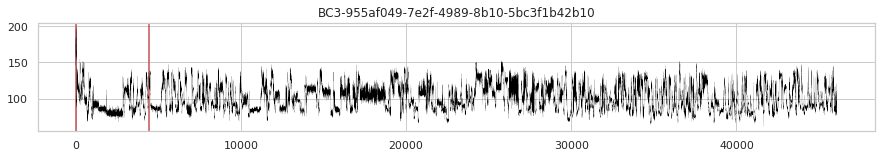

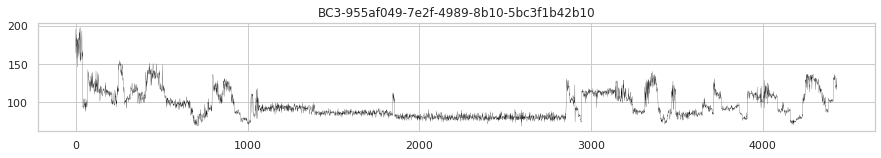

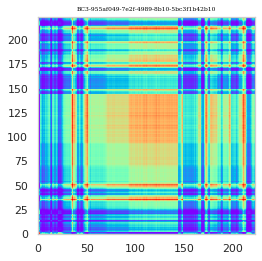

Number of Squiggles= 123
8.759355545043945  seconds
BC1 = 15880 samples now
BC2 = 10757 samples now
BC4 = 767 samples now
BC3 = 123 samples now
File name= /data/nanopore/James/Barcodes/rep4/rep4_cc6m_2709_T7_ecorv_cc4.txt_squiggle.tsv
Processing file: rep4_cc6m_2709_T7_ecorv_cc4.txt_squiggle.tsv
Reading: 01e9893d-e1c8-42bb-a4d5-0bc1f817a213


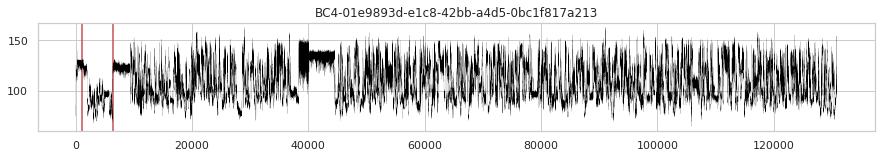

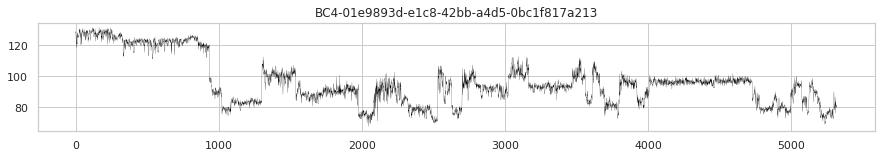

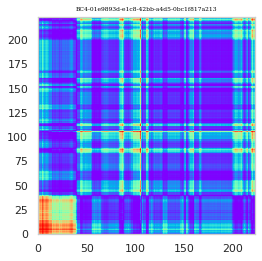

Reading: 022184ef-350a-47ae-8b30-0939452cd52c


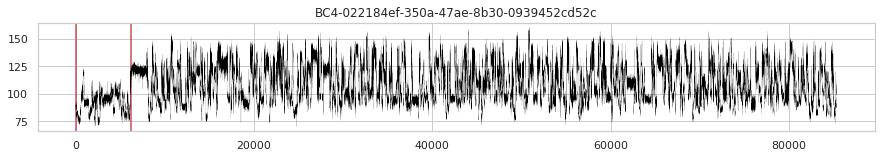

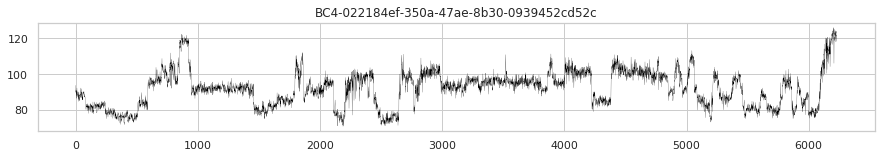

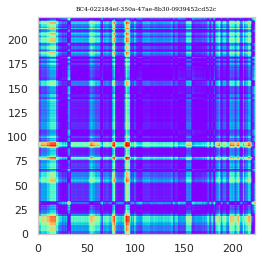

Reading: 02ab1365-8faa-4798-a180-df5126c825c7


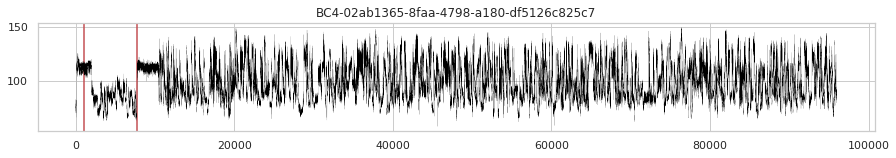

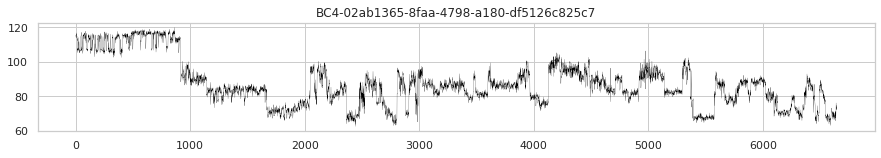

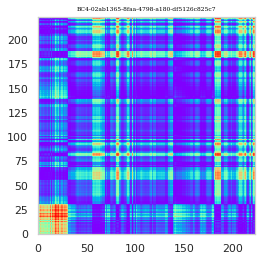

Reading: 02fe252f-2b4a-4062-bd7e-b5bc719a58c1


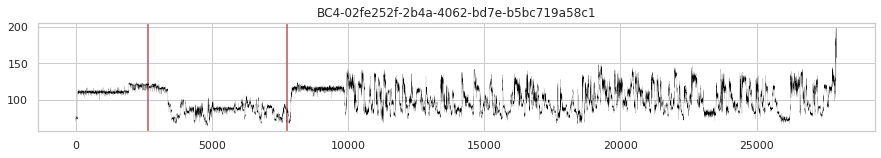

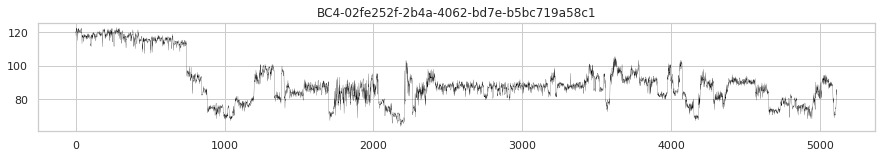

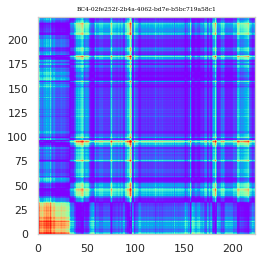

Reading: 04119e8d-72c9-4c02-b2ab-8d7a92c5eaf3


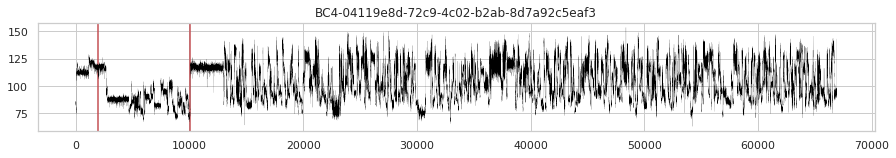

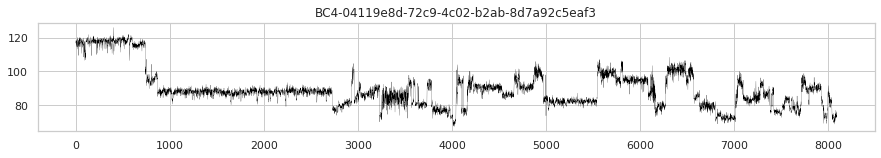

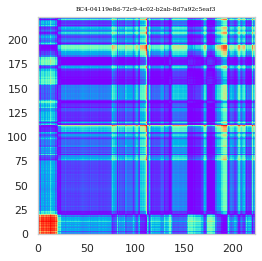

Number of Squiggles= 15309
478.84517645835876  seconds
BC1 = 15880 samples now
BC2 = 10757 samples now
BC4 = 16076 samples now
BC3 = 123 samples now
File name= /data/nanopore/James/Barcodes/rep4/rep4_cc6m_2595_T7_ecorv_cc3.txt_squiggle.tsv
Processing file: rep4_cc6m_2595_T7_ecorv_cc3.txt_squiggle.tsv
Reading: 0023230d-fcba-40f7-a6e3-b4575fe47c2c


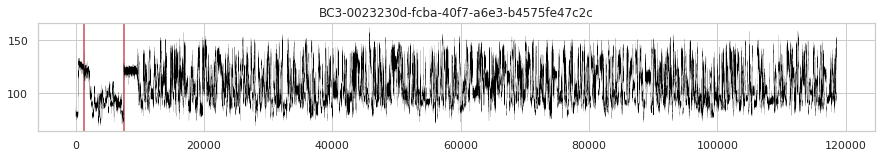

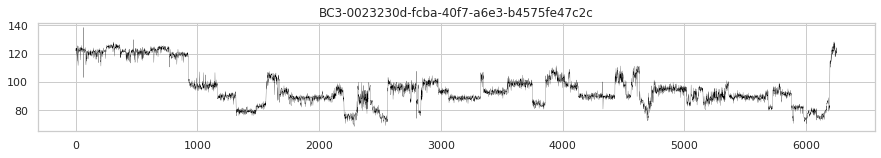

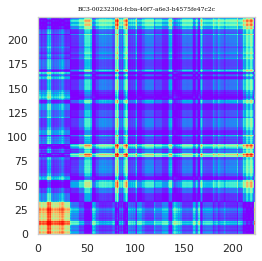

Reading: 005d27eb-f36f-46f9-944b-45a79849a550


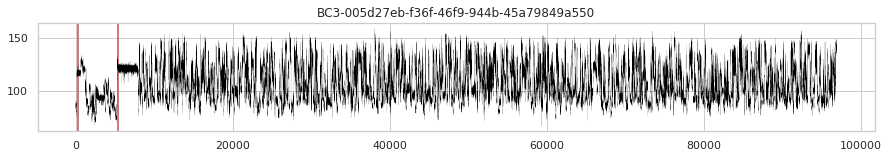

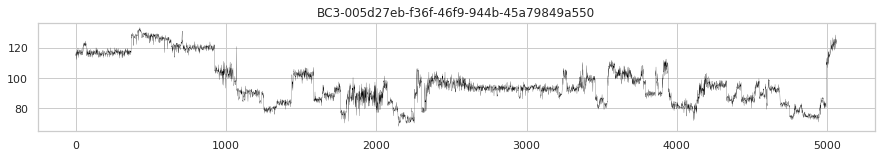

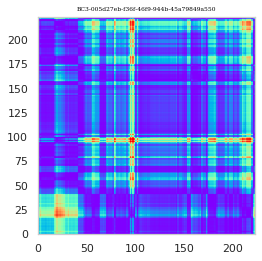

Reading: 00c29052-4054-493a-9814-b908d8c6a3ea


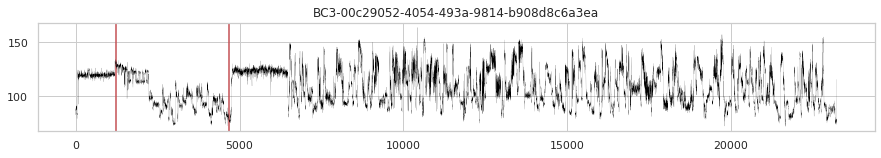

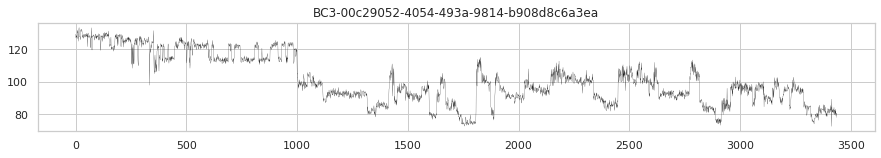

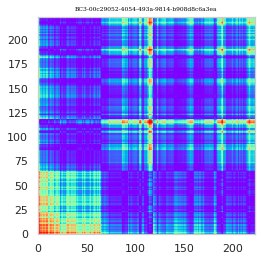

Reading: 00cf681d-10d4-4905-8e81-09a37a5d1f33


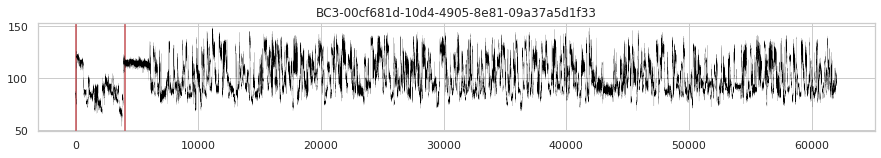

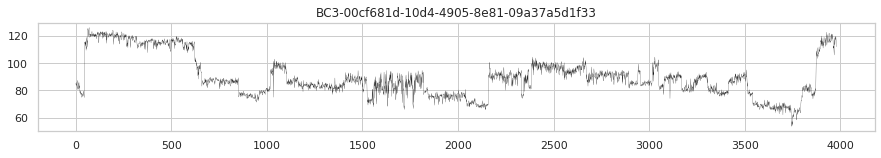

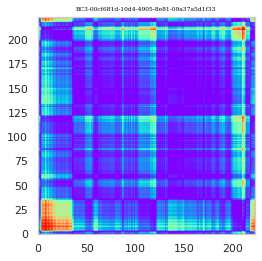

Reading: 014001b3-be18-4f54-b66d-baa71418e022


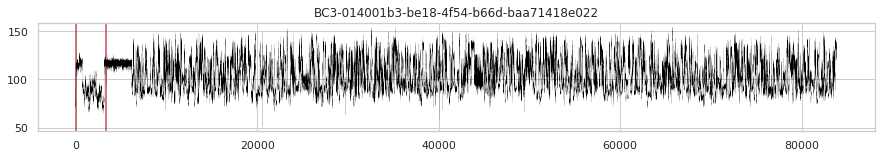

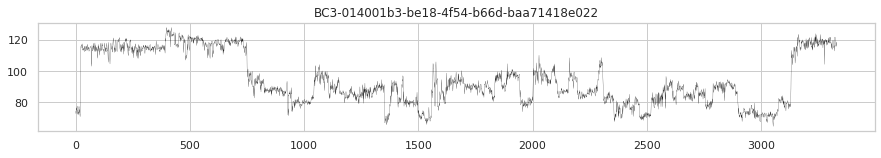

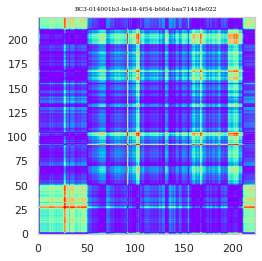

Number of Squiggles= 17814
617.7428278923035  seconds
BC1 = 15880 samples now
BC2 = 10757 samples now
BC4 = 16076 samples now
BC3 = 17937 samples now
CPU times: user 27min 6s, sys: 3min 46s, total: 30min 52s
Wall time: 29min 50s


In [24]:
%%time

result={}
for data_path in input_data_paths:
    print(data_path)
    for fn in all_files_in_path(data_path,'','squiggle.tsv'):
        file_name=data_path+'/'+fn
        print('File name=',file_name)
        summary=process_file(data_path,fn, 5, 10)
        for label, squiggle_label, img in summary:
            if label not in result:
                result[label]=[]
            result[label].append([squiggle_label,img])
        for key,value in result.items():
            print(key, '=',len(value), 'samples now')
#segments=None #No need after conversion

In [57]:
print(samples)

{'BC1': 15880, 'BC2': 10757, 'BC3': 17937, 'BC4': 16076}


In [85]:
for i,v in times.items():
    print(i, sum(v), len(v),sum(v)/len(v))

GramianAngularField-difference 2.5231733322143555 676 0.003732504929311177
GramianAngularField-summation 1.788696050643921 676 0.0026460000749170425
RecurrencePlot 816.8403627872467 676 1.2083437319337968
MarkovTransitionField 425.528954744339 676 0.6294807022845251


In [45]:
#%%time
#import pickle
#with open('images.px', 'wb') as fp:
#    pickle.dump(result, fp, protocol=4) 

4.248104572296143  seconds


In [48]:
#%%time
#with open ('images.px', 'rb') as fp:
#    result = pickle.load(fp, encoding="bytes") 

0.46711015701293945  seconds


In [25]:
print([len(val) for val in result.values()])

[15880, 10757, 16076, 17937]


In [26]:
for key,value in result.items():
    print(key,len(value))
    
#SH1= 75685  SH2= 82725  SH3= 60041  SH4= 80367 Previous runs
#SH1= 75034  SH2= 154149  SH3= 62744  SH4= 165525 Previous runs

BC1 15880
BC2 10757
BC4 16076
BC3 17937


In [27]:
np.mean([np.mean(elm[1]) for elm in result['BC4']])

-0.6424876850033757

In [39]:
43994+21129+22271+36780

124174

In [28]:
from sklearn.utils import shuffle

train_size=0
test_size=60650
test_val_split=0.99999
def prep_data(in_labels,raw_data,desired_size,y_value,shuffle_data=False,):
    data=deepcopy(raw_data)
    labels=deepcopy(in_labels)
    if shuffle_data:
        labels,data=shuffle(in_labels,data)
    data=data[0:desired_size]
    labels=labels[0:desired_size]
    results = np.empty((len(data),num_classes))
    results[0:len(data)]=y_value
    return(labels,data,results)
    
sh1=np.array(result['BC1'])
sh2=np.array(result['BC2'])
sh3=np.array(result['BC3'])
sh4=np.array(result['BC4'])
sh1d=np.vstack(sh1[:,1])
sh2d=np.vstack(sh2[:,1])
sh3d=np.vstack(sh3[:,1])
sh4d=np.vstack(sh4[:,1])
#result=None
labels,data,exp_values=prep_data(sh1[:,0],sh1d,train_size,[1,0,0,0],shuffle_data=True)
LX=labels
X=np.array(data)
y=exp_values
labels,data,exp_values=prep_data(sh1[:,0][train_size:],sh1d[train_size:],test_size,[1,0,0,0],shuffle_data=False)
LX_test=labels
X_test=np.array(data)
Y_test=exp_values
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', LX.shape, X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

labels,data,exp_values=prep_data(sh2[:,0],sh2d,train_size,[0,1,0,0],shuffle_data=True)
LX=np.append(LX,labels, axis=0)
X=np.append(X,data,axis=0)
y = np.append(y,exp_values,axis=0)
labels,data,exp_values=prep_data(sh2[:,0][train_size:],sh2d[train_size:],test_size,[0,1,0,0],shuffle_data=False)
LX_test=np.append(LX_test,labels,axis=0)
X_test=np.append(X_test,data,axis=0)
Y_test = np.append(Y_test,exp_values,axis=0)
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', len(LX), X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

labels,data,exp_values=prep_data(sh3[:,0],sh3d,train_size,[0,0,1,0],shuffle_data=True)
LX=np.append(LX,labels, axis=0)
X=np.append(X,data,axis=0)
y = np.append(y,exp_values,axis=0)
labels,data,exp_values=prep_data(sh3[:,0][train_size:],sh3d[train_size:],test_size,[0,0,1,0],shuffle_data=False)
LX_test=np.append(LX_test,labels,axis=0)
X_test=np.append(X_test,data,axis=0)
Y_test =np.append(Y_test,exp_values,axis=0)
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', len(LX), X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

labels,data,exp_values=prep_data(sh4[:,0],sh4d,train_size,[0,0,0,1],shuffle_data=True)
LX=np.append(LX,labels, axis=0)
X=np.append(X,data,axis=0)
y = np.append(y,exp_values,axis=0)
labels,data,exp_values=prep_data(sh4[:,0][train_size:],sh4d[train_size:],test_size,[0,0,0,1],shuffle_data=True)
LX_test=np.append(LX_test,labels,axis=0)
X_test=np.append(X_test,data,axis=0)
Y_test = np.append(Y_test,exp_values,axis=0)
print ( 'lx,x,y,labels, lxt, x_test y_test shapes=', len(LX), X.shape,y.shape,len(labels), len(LX_test),X_test.shape, Y_test.shape)

#del result,sh1,sh2,sh3,sh4,sh1d,sh2d,sh3d,sh4d
#X_test_labels, X_test, Y_test=
#X_validation_labels, X_validation, Y_validation =train_test_split(X_test, y_test, test_size=0.5, shuffle=True)
LX_test, X_test, Y_test=shuffle(LX_test, X_test, Y_test)
split_point=int(len(X_test)*test_val_split)
print("splitting at=",split_point)
LX_validation=LX_test[split_point:]
X_validation=X_test[split_point:]
Y_validation=Y_test[split_point:]
LX_test=LX_test[0:split_point]
X_test=X_test[0:split_point]
Y_test=Y_test[0:split_point]

print('Tst LX=', len(LX_test))
print('Tst X=', X_test.shape)
print('Tst y=',Y_test.shape)
print('Val LX=', len(LX_validation))
print('Val X=', X_validation.shape)
print('Val y=',Y_validation.shape)


lx,x,y,labels, lxt, x_test y_test shapes= (0,) (0, 1, 224, 224) (0, 4) 15880 15880 (15880, 1, 224, 224) (15880, 4)
lx,x,y,labels, lxt, x_test y_test shapes= 0 (0, 1, 224, 224) (0, 4) 10757 26637 (26637, 1, 224, 224) (26637, 4)
lx,x,y,labels, lxt, x_test y_test shapes= 0 (0, 1, 224, 224) (0, 4) 17937 44574 (44574, 1, 224, 224) (44574, 4)
lx,x,y,labels, lxt, x_test y_test shapes= 0 (0, 1, 224, 224) (0, 4) 16076 60650 (60650, 1, 224, 224) (60650, 4)
splitting at= 60649
Tst LX= 60649
Tst X= (60649, 1, 224, 224)
Tst y= (60649, 4)
Val LX= 1
Val X= (1, 1, 224, 224)
Val y= (1, 4)


In [ ]:
X_test[0]

In [29]:
"""Defines a ResNet on the nanopore dataset.

ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf

ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""
#tensorboard = keras.callbacks.TensorBoard(log_dir="log-full/{}".format(time.time()), histogram_freq=20, write_graph=True)

# Training parameters
batch_size = 32*gpus  # multiply by number of GPUs 
data_augmentation = False

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
    
X_train=X
Y_train=y

In [30]:
print(X_test)

[[[[-0.21564384 -0.32831052 -0.31651471 ...  0.3402782   0.14617971
     0.15304903]
   [-0.32831052 -0.43647555 -0.42523027 ...  0.2280257   0.02953784
     0.03648157]
   [-0.31651471 -0.42523027 -0.41391896 ...  0.24014074  0.04199114
     0.04893148]
   ...
   [ 0.3402782   0.2280257   0.24014074 ...  0.79059288  0.65279581
     0.658043  ]
   [ 0.14617971  0.02953784  0.04199114 ...  0.65279581  0.48884207
     0.49489106]
   [ 0.15304903  0.03648157  0.04893148 ...  0.658043    0.49489106
     0.50091616]]]


 [[[ 0.18202631  0.16933996  0.1779202  ... -0.01341642  0.01932378
    -0.10776076]
   [ 0.16933996  0.15662549  0.16522451 ... -0.02630067  0.00643806
    -0.12056329]
   [ 0.1779202   0.16522451  0.17381098 ... -0.0175902   0.01515013
    -0.11190978]
   ...
   [-0.01341642 -0.02630067 -0.0175902  ... -0.20834297 -0.17621371
    -0.29975329]
   [ 0.01932378  0.00643806  0.01515013 ... -0.17621371 -0.14389556
    -0.26836198]
   [-0.10776076 -0.12056329 -0.11190978 ... -0.

In [31]:
# Devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"

def _get_available_devices():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print (_get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']


In [32]:
# Model name, depth and version
model_type = 'UResNet%dv%d' % (depth, version)
print('model_type=',model_type)
# Input image dimensions.

input_shape = X_train.shape[1:]
print('input_shape=',input_shape)
# Normalize data.
"""
x_train = X_train #/ 255
x_test = X_test #/ 255
x_validation = X_validation #/ 255
"""
x_train = X_train +1
x_train /= 2
x_test = X_test+1
x_test /= 2 
x_validation = X_validation +1
x_validation /= 2

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    print (x_train_mean)
    x_train -= x_train_mean
    x_test -= x_train_mean
    x_validation -= x_train_mean
    

print('x_train shape:', x_train.shape)
print(x_test.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_validation.shape[0], 'validation samples')
print('y_train shape:', Y_train.shape)

# Convert class vectors to binary class matrices.
y_train = Y_train #keras.utils.to_categorical(Y_train, num_classes)
y_test = Y_test #keras.utils.to_categorical(Y_test, num_classes)
y_validation=Y_validation

model_type= UResNet20v2
input_shape= (1, 224, 224)
x_train shape: (0, 1, 224, 224)
60649 train samples
60649 test samples
1 validation samples
y_train shape: (0, 4)


In [33]:
np.mean([np.mean(elm) for elm in x_test])

0.1757256359735928

In [34]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 10, 20, 30, 50 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 50:
        lr *= 0.5e-3
    elif epoch > 35:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [35]:
from keras.models import load_model
model = load_model('/data/nanopore/James/Barcodes/saved_models/pAmps-rep3-5-train1_newdata_nanopore_UResNet20v2_model.037.h5')
#model = load_model('saved_models/run03_nanopore_UResNet20v2_model.045.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [86]:
model.compile(loss='categorical_crossentropy',
            optimizer=Adam(lr=lr_schedule(0)),
            metrics=['accuracy'])

Learning rate:  0.001


In [34]:
x_validation[0]

array([[[1.78651439e-01, 1.29268649e-01, 1.19670989e-01, ...,
         5.53941255e-02, 4.37675731e-03, 3.12588997e-06],
        [1.29268649e-01, 8.68569607e-02, 7.88435196e-02, ...,
         2.82806667e-02, 5.81585500e-06, 4.94587977e-03],
        [1.19670989e-01, 7.88435196e-02, 7.11861669e-02, ...,
         2.36603140e-02, 2.87304726e-04, 7.19481790e-03],
        ...,
        [5.53941255e-02, 2.82806667e-02, 2.36603140e-02, ...,
         1.50357244e-03, 1.74792795e-02, 3.96921145e-02],
        [4.37675731e-03, 5.81585500e-06, 2.87304726e-04, ...,
         1.74792795e-02, 8.95928234e-02, 1.32086076e-01],
        [3.12588997e-06, 4.94587977e-03, 7.19481790e-03, ...,
         3.96921145e-02, 1.32086076e-01, 1.81368484e-01]]])

In [36]:
# Validate trained model.
scores = model.evaluate(x_validation, y_validation, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])
#print(scores) 0.950775

1/1 [==============================] - 8s 8s/step
Validation loss: 0.07610195875167847
Validation accuracy: 1.0


In [37]:
# Test trained model.
test_scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
#print(test_scores)
#Test loss: 0.2965975133061409
#Test accuracy: 0.951825


60649/60649 [==============================] - 196s 3ms/step
Test loss: 0.6869584223334045
Test accuracy: 0.82858744579662


In [38]:
y_predicted = model.predict(x_validation, verbose=1)


1/1 [==============================] - 14s 14s/step


In [38]:
y_val_pred=np.round(y_predicted,decimals=2)
y_val_act=np.round(y_validation,decimals=2)
print(y_val_pred[10:50])
print(y_val_act[10:50])
y_val_pred_act=np.concatenate((y_val_pred,y_val_act), axis = 1 )

[]
[]


In [48]:
def  spectifity(true_negatives,false_positives):
    return(true_negatives/(true_negatives+false_positives))

def sensitivity(true_positives,false_negatives):
    return(true_positives/(true_positives+false_negatives))

def confidence_margin(npa):
    sorted=np.sort(npa)[::-1]    #return sort in reverse, i.e. descending
    return(sorted[0])#-sorted[1])
print(confidence_margin([0.0, 0.0, 0.5, 0.0]))

def result_for(npa):
    half=len(npa)//2
    return(np.argmax(npa[0:half])==np.argmax(npa[half:]))

#print(result_for(np.array([0.0, 1.0, 0.5, 0.0, 0.8,0.1, 0.2, 0.1])))

def confidence_corr(npa):
    half=len(npa)//2
    res=result_for(npa)
    cm=confidence_margin(npa[0:half])
    return(res,cm)

def totals_for(combined_results,treshold=0.5 ):
    tt,tf,th,tl,fh,fl=0,0,0,0,0,0
    for y in y_val_pred_act:
        res,cm=confidence_corr(y)
        if res:
            tt=tt+1
            if cm>treshold:
                th=th+1
            else:
                tl=tl+1
        else:
            tf=tf+1
            if cm>treshold:
                fh=fh+1
            else:
                fl=fl+1
    return(tt,tf,th,tl,fh,fl)

def vectorise_with_threshold(predictions,threshold):
    vectorised=[]
    for pred in predictions:
        if confidence_margin(pred)>threshold:
            vectorised.append(np.argmax(pred)+1)
        else:
            vectorised.append(0)
    return(np.array(vectorised))

def vectorise_selected_with_threshold(predictions,actuals, threshold):
    vectorised=[]
    vect_act=[]
    for index,pred in enumerate(predictions):
        if confidence_margin(pred)>threshold:
            vectorised.append(np.argmax(pred)+1)
            vect_act.append(np.argmax(actuals[index])+1)
    return(np.array(vectorised),np.array(vect_act))

def vectorise_and_select_with_threshold(labels,predictions,actuals, threshold):
    sel_labels=[]
    vectorised=[]
    vect_act=[]
    for index,pred in enumerate(predictions):
        if confidence_margin(pred)>threshold:
            sel_labels.append(labels[index])
            vectorised.append(np.argmax(pred)+1)
            vect_act.append(np.argmax(actuals[index])+1)
    return(sel_labels,np.array(vectorised),np.array(vect_act))

0.5


In [40]:
y_test_predicted = model.predict(x_test, verbose=1)

60649/60649 [==============================] - 174s 3ms/step


In [41]:
y_predicted = model.predict(x_validation, verbose=1)

1/1 [==============================] - 0s 27ms/step


In [42]:
def keys_numbers_to_strings(dict):
    dict={}
    for key, name in dict.iteritems():
        strdict[str(key)] = dict[key]

In [43]:
def export_errors(file_name,labels, predictions, actuals):
    with open(run+"/"+file_name, "w") as file:
        for index,pred in enumerate(predictions):
            if actuals[index]!=pred:
                file.write(labels[index]+','+ str(pred)+ ','+str(actuals[index])+'\n')
                
def export_matrix(file_name,labels, matrix):
    with open(run+"/"+file_name, "w") as file:
        for index,mat_row in enumerate(matrix):
            file.write(labels[index])
            for elem in mat_row:
                file.write(','+ str(elem))
            file.write('\n')
                
# export predictions and actuals


In [101]:
export_matrix('test_predictions.csv',LX_test, y_test_predicted)
export_matrix('test_actuals.csv',LX_test, y_test)
export_matrix('val_predictions.csv',LX_validation, y_predicted)
export_matrix('val_actuals.csv',LX_test, y_validation)

In [49]:
def totals_for(cm_table):
    correct,incorrect=0,0
    for i in range(1,5):
        for j in range(1,5):
            if i==j:
                correct=correct+cm_table[i][j]
            else:
                incorrect=incorrect+cm_table[i][j]
    total=correct+incorrect
    return([total,correct,incorrect])

def cm_heatmap_for(cm_table, threshold):
    df_cm = pd.DataFrame(cm_table, index =[1,2,3,4],columns = [1,2,3,4])
    plt.figure(figsize = (4,3))
    ax = plt.axes()
    ax.set_title("Result="+str(threshold))
    sn.heatmap(df_cm, annot=True,fmt='g', ax = ax)#,annot_kws=annot_kws)# ,mask=mask)
    plt.savefig(run+'/confusion_matrix_'+str(threshold)+'.svg', format="svg")
    plt.show()
    
def cm_for_threshold(labels,predicted,actual,threshold=0.5,dump_errors=False):
    result={}
#    pv=vectorise_with_threshold(predicted,threshold)
#    av=vectorise_with_threshold(actual,threshold) 
    sel_labels,pv,av=vectorise_and_select_with_threshold(labels,predicted,actual, threshold)
    result['total']=len(predicted)
    result['recovered']=len(pv)
    result['discarded']=len(predicted)-result['recovered']  
    cm = ConfusionMatrix(actual_vector=av, predict_vector=pv)
    result['cm']=cm
    total,correct,incorrect=totals_for(cm.table)
    result['correct']=correct
    result['incorrect']=incorrect
    if dump_errors: 
        export_errors('classification_errors_'+str(threshold),labels, pv, av)
    return(result)
#        for index,pred in enumerate(pv):
#            if av[index]!=pred:
#                print(labels[index],',', pred, ',',av[index])

In [45]:
y_test

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [78]:
y_test_mod=[[elem[3],elem[0],elem[2],elem[1]] for elem in y_test]
np.array(y_test_mod)

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

Total= 60649  Classified= 60649 Discarded= 0 recovered percent= 100.0 discarded percent= 0.0
Correct= 50253 Incorrect= 10396 Correct %= 82.85874457946545 Incorrect %= 17.141255420534552


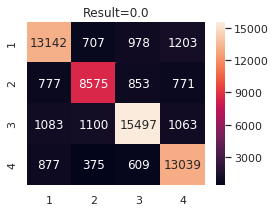

Total= 60649  Classified= 60649 Discarded= 0 recovered percent= 100.0 discarded percent= 0.0
Correct= 50253 Incorrect= 10396 Correct %= 82.85874457946545 Incorrect %= 17.141255420534552


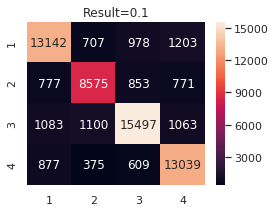

Total= 60649  Classified= 60649 Discarded= 0 recovered percent= 100.0 discarded percent= 0.0
Correct= 50253 Incorrect= 10396 Correct %= 82.85874457946545 Incorrect %= 17.141255420534552


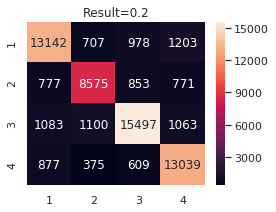

Total= 60649  Classified= 60645 Discarded= 4 recovered percent= 99.99340467278934 discarded percent= 0.006595327210671239
Correct= 50250 Incorrect= 10395 Correct %= 82.8592629235716 Incorrect %= 17.140737076428394


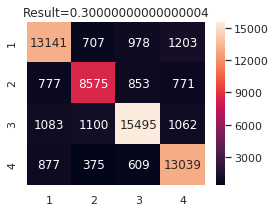

Total= 60649  Classified= 60317 Discarded= 332 recovered percent= 99.45258784151429 discarded percent= 0.5474121584857129
Correct= 50143 Incorrect= 10174 Correct %= 83.13245022133063 Incorrect %= 16.867549778669364


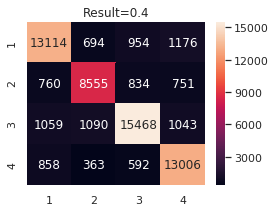

Total= 60649  Classified= 58938 Discarded= 1711 recovered percent= 97.17884878563538 discarded percent= 2.821151214364623
Correct= 49623 Incorrect= 9315 Correct %= 84.19525603176218 Incorrect %= 15.804743968237808


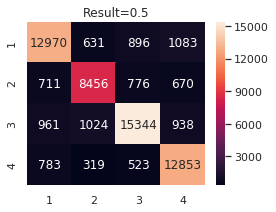

Total= 60649  Classified= 55938 Discarded= 4711 recovered percent= 92.23235337763195 discarded percent= 7.767646622368051
Correct= 48304 Incorrect= 7634 Correct %= 86.35274768493689 Incorrect %= 13.647252315063104


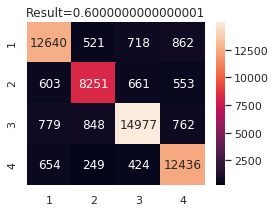

Total= 60649  Classified= 52909 Discarded= 7740 recovered percent= 87.23804184735116 discarded percent= 12.761958152648848
Correct= 46808 Incorrect= 6101 Correct %= 88.46888053072256 Incorrect %= 11.531119469277439


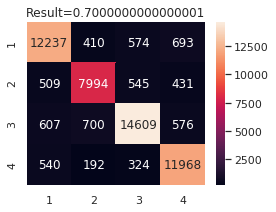

Total= 60649  Classified= 49442 Discarded= 11207 recovered percent= 81.52154198750185 discarded percent= 18.478458012498145
Correct= 44827 Incorrect= 4615 Correct %= 90.66583067028033 Incorrect %= 9.334169329719671


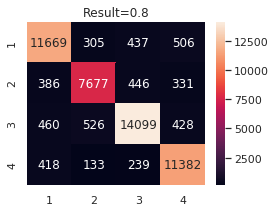

Total= 60649  Classified= 44408 Discarded= 16241 recovered percent= 73.2213226928721 discarded percent= 26.7786773071279
Correct= 41463 Incorrect= 2945 Correct %= 93.368312015853 Incorrect %= 6.631687984147


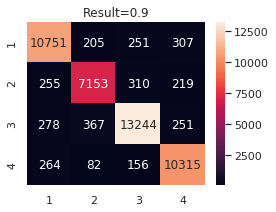

In [50]:
from pycm import *
stats={}
for threshold in np.arange(0,1,0.1):
    result=cm_for_threshold(LX_test,y_test_predicted,y_test,threshold=threshold,dump_errors=True)
    print("Total=",result['total']," Classified=", result['recovered'], 
          "Discarded=",result['discarded'], "recovered percent=",result['recovered']/result['total'] *100, "discarded percent=",(result['total']-result['recovered'])/result['total']*100)
    print('Correct=',result['correct'],'Incorrect=',result['incorrect'], 
          'Correct %=',result['correct']/result['recovered'] * 100,'Incorrect %=',result['incorrect']/result['recovered'] * 100) 
    cm=result['cm']
    cm_heatmap_for(cm.table, threshold)
#    print(cm)
    stats[str(threshold)]=result

In [ ]:
def export_errors(file_name,labels, predictions, actuals):
    with open(run,"/"+file_name, "w") as file:
        for index,pred in enumerate(predictions):
            if actuals[index]!=pred:
                file.write(labels[index]+','+ str(pred)+ ','+str(actuals[index])+'\n')
                
def export_matrix(run,"/"+file_name,labels, matrix):
    with open(file_name, "w") as file:
        for index,mat_row in enumerate(matrix):
            file.write(labels[index])
            for elem in mat_row:
                file.write(','+ str(elem))
            file.write('\n')
                

In [ ]:
export_matrix('rep4-test_predictions.csv',LX_test, y_test_predicted)
export_matrix('rep4-test_actuals.csv',LX_test, y_test)


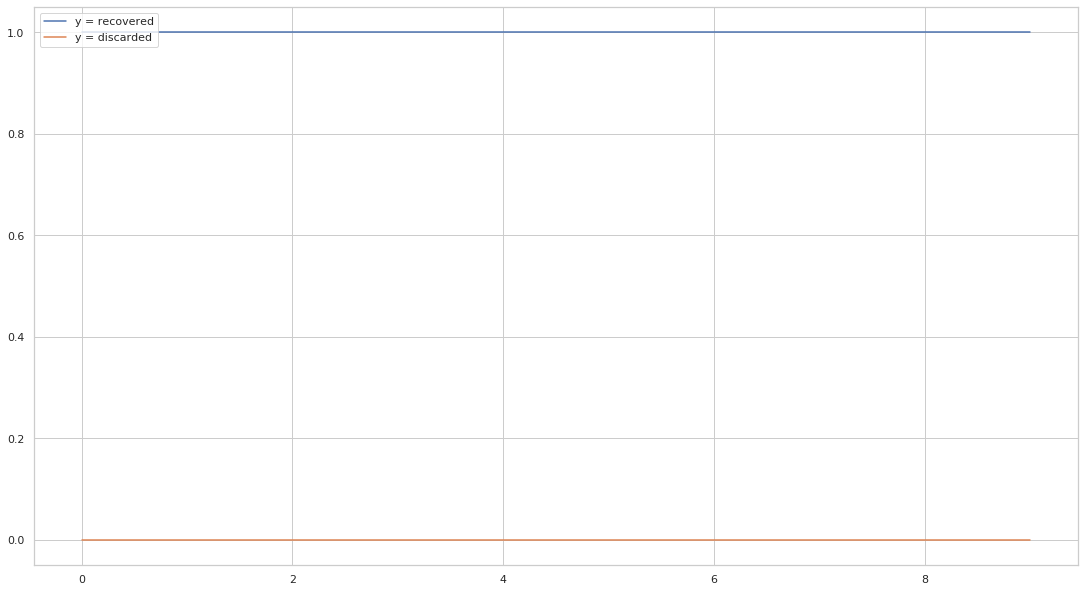

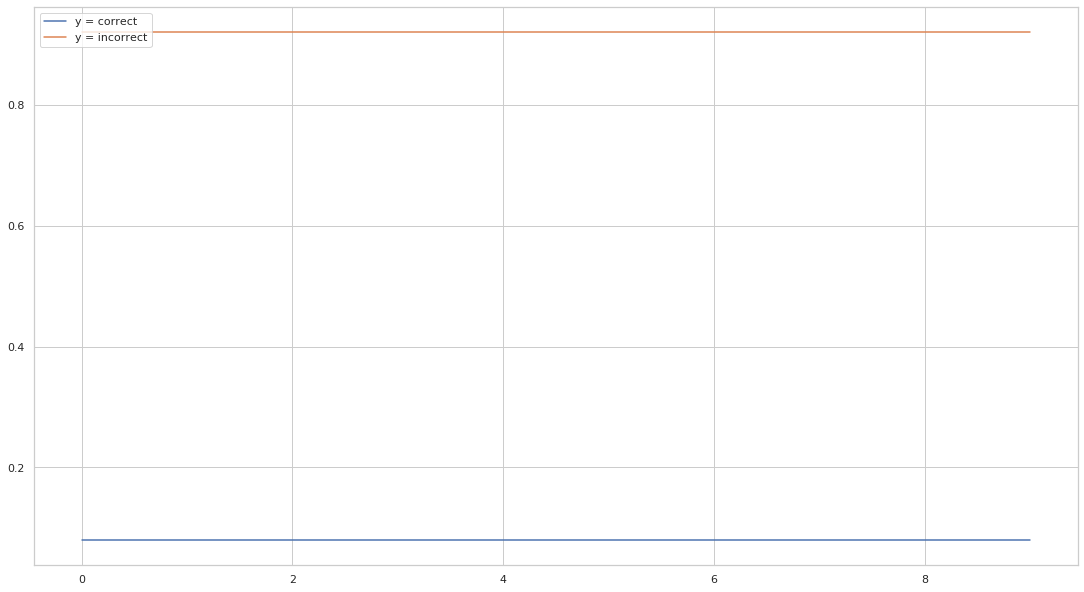

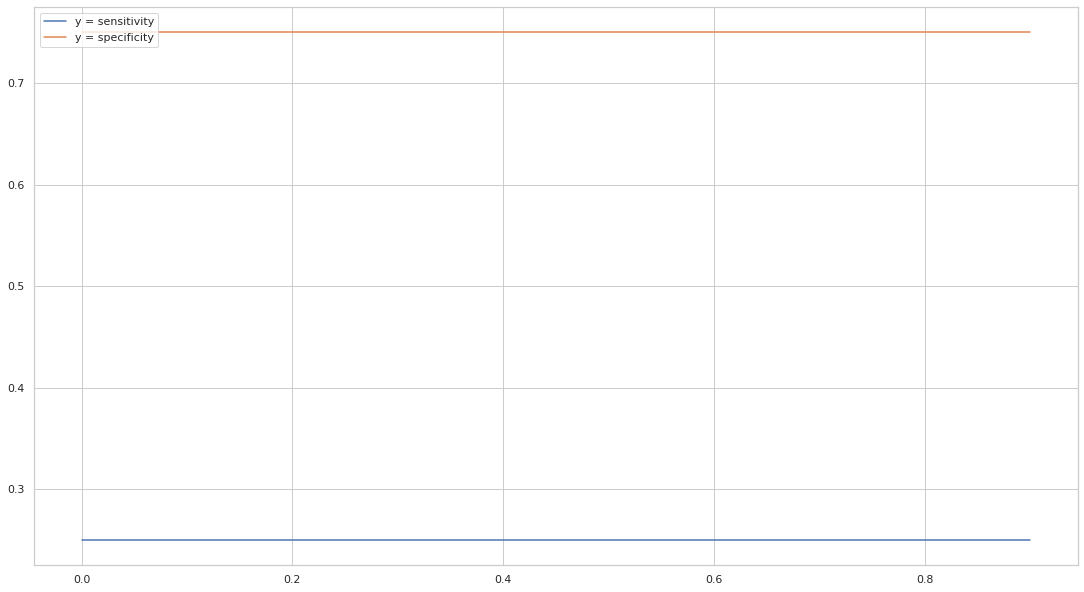

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08] [0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92] [0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]
0.0 1.0 0.0 0.08 0.92
0.1 1.0 0.0 0.08 0.92
0.2 1.0 0.0 0.08 0.92
0.30000000000000004 1.0 0.0 0.08 0.92
0.4 1.0 0.0 0.08 0.92
0.5 1.0 0.0 0.08 0.92
0.6000000000000001 1.0 0.0 0.08 0.92
0.7000000000000001 1.0 0.0 0.08 0.92
0.8 1.0 0.0 0.08 0.92
0.9 1.0 0.0 0.08 0.92


In [83]:
def calc_avg(dict):
    vals=np.array(list(dict.values()))
    return(np.mean(vals))

def calculate_stats(result):
    confidence=[]
    recovered=[]
    discarded=[]
    correct=[]
    incorrect=[]
    accuracy=[]    
    sensitivity=[]
    specificity=[]
    roc=[]
    for conf,scores in result.items():
        confidence.append(float(conf))
        recovered.append(scores['recovered']/scores['total'])
        discarded.append(scores['discarded']/scores['total'])
        correct.append(scores['correct']/scores['recovered'])
        incorrect.append(scores['incorrect']/scores['recovered'])
        accuracy.append(scores['cm'].Overall_ACC)
        sensitivity.append(calc_avg(scores['cm'].TPR))
        specificity.append(calc_avg(scores['cm'].TNR))
        roc.append(calc_avg(scores['cm'].AUC))    
    return(confidence,recovered,discarded,correct,incorrect,accuracy,sensitivity,specificity,roc)
        
    plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

def graph_summary_for(result):
    confidence,recovered,discarded,correct,incorrect,accuracy,sensitivity,specificity,roc=calculate_stats(result)
    plt.plot(recovered)
    plt.plot(discarded)
    plt.legend(['y = recovered', 'y = discarded'], loc='upper left')
    plt.show()
    
    plt.plot(correct)
    plt.plot(incorrect)
    plt.legend(['y = correct', 'y = incorrect'], loc='upper left')
    plt.show()
    
    plt.plot(confidence,sensitivity)
    plt.plot(confidence,specificity)
    plt.legend(['y = sensitivity', 'y = specificity'], loc='upper left')
    plt.show()
    print(confidence,recovered,discarded,correct,incorrect,accuracy)
    for index,cf in enumerate(confidence):
        print(cf,recovered[index],discarded[index],correct[index],incorrect[index])

graph_summary_for(stats)

[2584, 2304, 280, 0.891640866873065, 0.10835913312693499]
Predict          1      2      3      4      
Actual
1                516    43     20     15     

2                121    271    12     7      

3                4      12     762    13     

4                7      11     15     755    





Overall Statistics : 

95% CI                                                           (0.87966,0.90363)
AUNP                                                             0.9288
AUNU                                                             0.91339
Bennett S                                                        0.85552
CBA                                                              0.83832
Chi-Squared                                                      5459.63637
Chi-Squared DF                                                   9
Conditional Entropy                                              0.53897
Cramer V                                                         0.83922
Cross Entro

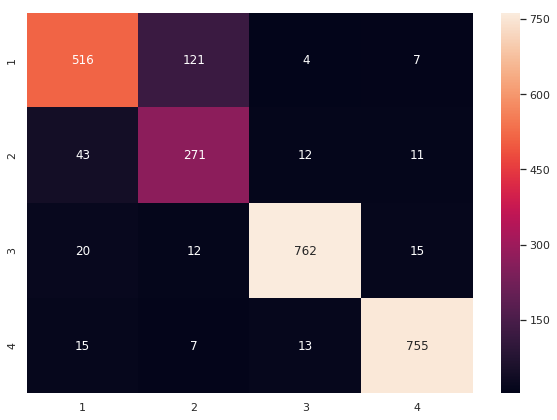

In [42]:
cm = ConfusionMatrix(actual_vector=av, predict_vector=pv)
cm_table=cm.table
print(totals_for(cm_table))
print(cm)
#cm.relabel(mapping={0:"117",1:"63",2:"81",3:"103",4:"999"})
df_cm = pd.DataFrame(cm.table, index =[1,2,3,4],
                  columns = [1,2,3,4])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g' )

In [ ]:
threshold=0.9
pv,av=vectorise_selected_with_threshold(y_test_predicted,y_test,threshold)
recognised=np.count_nonzero(pv)


In [ ]:
cm = ConfusionMatrix(actual_vector=av, predict_vector=pv)
cm_table=cm.table
print(totals_for(cm_table))
print(cm)
#cm.relabel(mapping={0:"117",1:"63",2:"81",3:"103",4:"999"})
df_cm = pd.DataFrame(cm.table, index =[1,2,3,4],
                  columns = [1,2,3,4])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g' )